## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [2]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

Mounted at /content/drive


Importing required libraries

In [4]:
import os, gc
import random
import shutil
import time, datetime
from thop import vision, profile, clever_format
from flopth import flopth
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cpu


Device (CPU/GPU) available to use.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.random.manual_seed(random_seed)

This notebook using device: cpu


Setting up logger and directories

In [6]:
try:
    ROOT
except NameError:
    ROOT="./results/"
    if not os.path.exists(ROOT):
        os.makedirs(ROOT)

print('ROOT Directory:', ROOT)

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"

logger = utils.get_logger(LOG_DIR)

ROOT Directory: /content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/


In [7]:
def clear_gpu_memory():
    gc.collect()
    torch.cuda.empty_cache()

## Single Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=1
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:03<00:00, 47841728.36it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                              model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                              prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter1_capsnet_cifar10_model.name = 'multilayer_inter1_capsnet_cifar10_model'
multilayer_inter1_capsnet_cifar10_model = multilayer_inter1_capsnet_cifar10_model.to(device)
multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter1_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 04:15:16 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5946, Top 1 Acc=10.94, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.5946, Top 1 Acc=10.94, Top 5 Acc=59.38
02/05 04:15:26 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4448, Top 1 Acc=33.32, Top 5 Acc=81.20
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4448, Top 1 Acc=33.32, Top 5 Acc=81.20
02/05 04:15:35 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4146, Top 1 Acc=39.01, Top 5 Acc=85.13
INFO:capsnet:multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4146, Top 1 Acc=39.01, Top 5 Acc=85.13
02/05 04:15:44 PM | multilayer_inter1_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.3985, Top 1 Acc=41.81, Top 5 Acc=87.0

CPU times: user 26min 54s, sys: 1min 16s, total: 28min 11s
Wall time: 28min 36s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter1_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter1_capsnet_cifar10_model.pt')

best_multilayer_inter1_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter1_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter1_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter1_capsnet_cifar10_model.name = 'best_multilayer_inter1_capsnet_cifar10_model'
best_multilayer_inter1_capsnet_cifar10_model = best_multilayer_inter1_capsnet_cifar10_model.to(device)
best_multilayer_inter1_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter1_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter1_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:28:10 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
02/17 02:28:10 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=96.094
02/17 02:28:10 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=96.875
02/17 02:28:11 AM | best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter1_capsnet_cifar10_model - Iterations=4/157

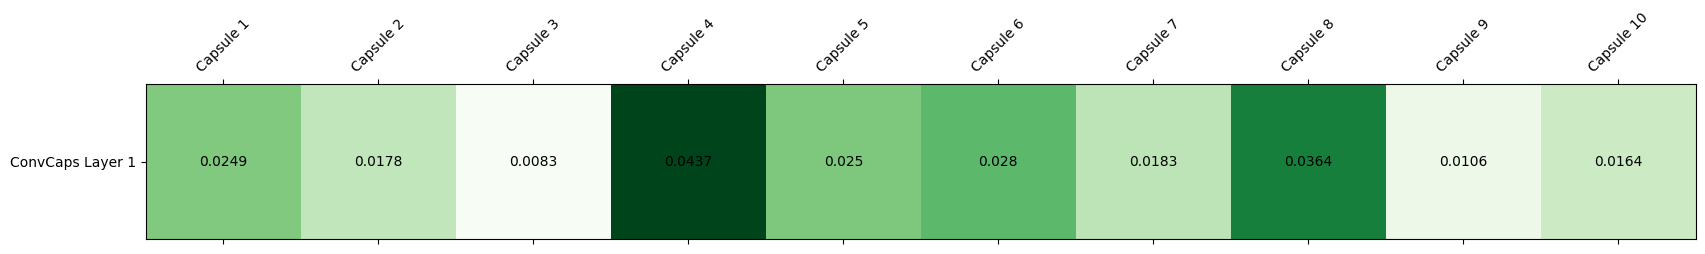

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

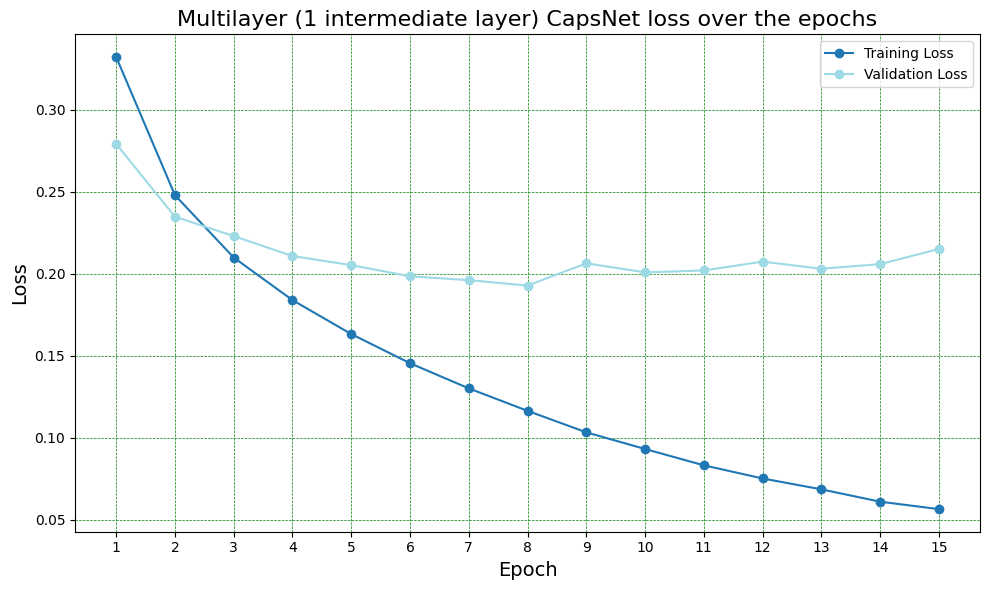

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (1 intermediate layer) CapsNet loss over the epochs')

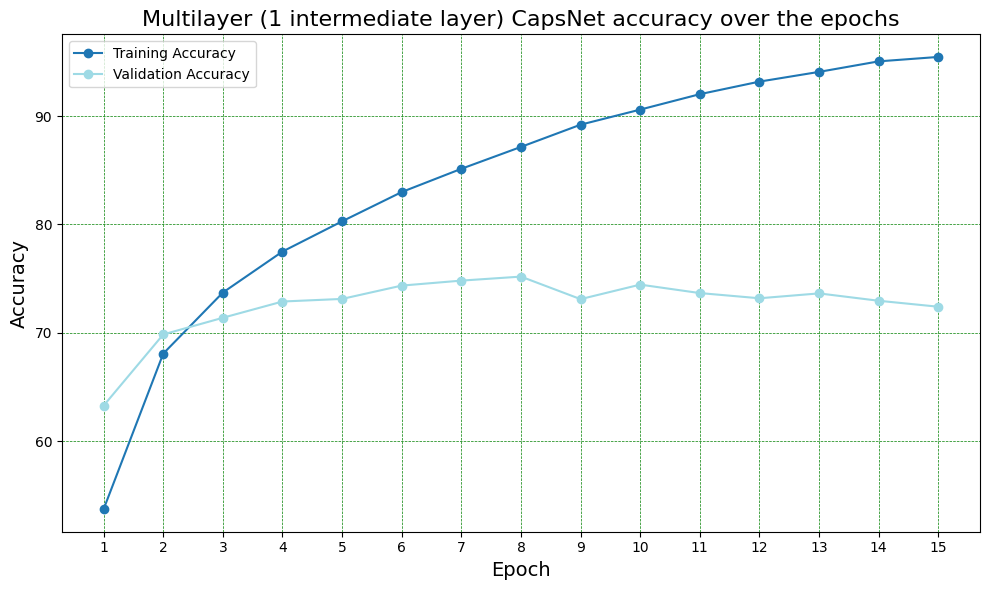

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (1 intermediate layer) CapsNet accuracy over the epochs')

## 2 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=2
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter2_capsnet_cifar10_model.name = 'multilayer_inter2_capsnet_cifar10_model'
multilayer_inter2_capsnet_cifar10_model = multilayer_inter2_capsnet_cifar10_model.to(device)
multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter2_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 04:43:54 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6797, Top 1 Acc=7.81, Top 5 Acc=46.88
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6797, Top 1 Acc=7.81, Top 5 Acc=46.88
02/05 04:44:07 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4585, Top 1 Acc=31.54, Top 5 Acc=79.13
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4585, Top 1 Acc=31.54, Top 5 Acc=79.13
02/05 04:44:21 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4260, Top 1 Acc=36.76, Top 5 Acc=83.83
INFO:capsnet:multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4260, Top 1 Acc=36.76, Top 5 Acc=83.83
02/05 04:44:34 PM | multilayer_inter2_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4072, Top 1 Acc=40.28, Top 5 Acc=85.89


CPU times: user 41min 37s, sys: 1min 50s, total: 43min 28s
Wall time: 44min 20s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter2_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter2_capsnet_cifar10_model.pt')

best_multilayer_inter2_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter2_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter2_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter2_capsnet_cifar10_model.name = 'best_multilayer_inter2_capsnet_cifar10_model'
best_multilayer_inter2_capsnet_cifar10_model = best_multilayer_inter2_capsnet_cifar10_model.to(device)
best_multilayer_inter2_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
  )
  (class_caps): CapsLayer()
)

In [ ]:
capsnet_inter2_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter2_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:30:02 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=98.438
02/17 02:30:02 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.906, Top 5 Acc=98.438
02/17 02:30:02 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.521, Top 5 Acc=97.396
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.521, Top 5 Acc=97.396
02/17 02:30:02 AM | best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=74.219, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter2_capsnet_cifar10_model - Iterations=4/157

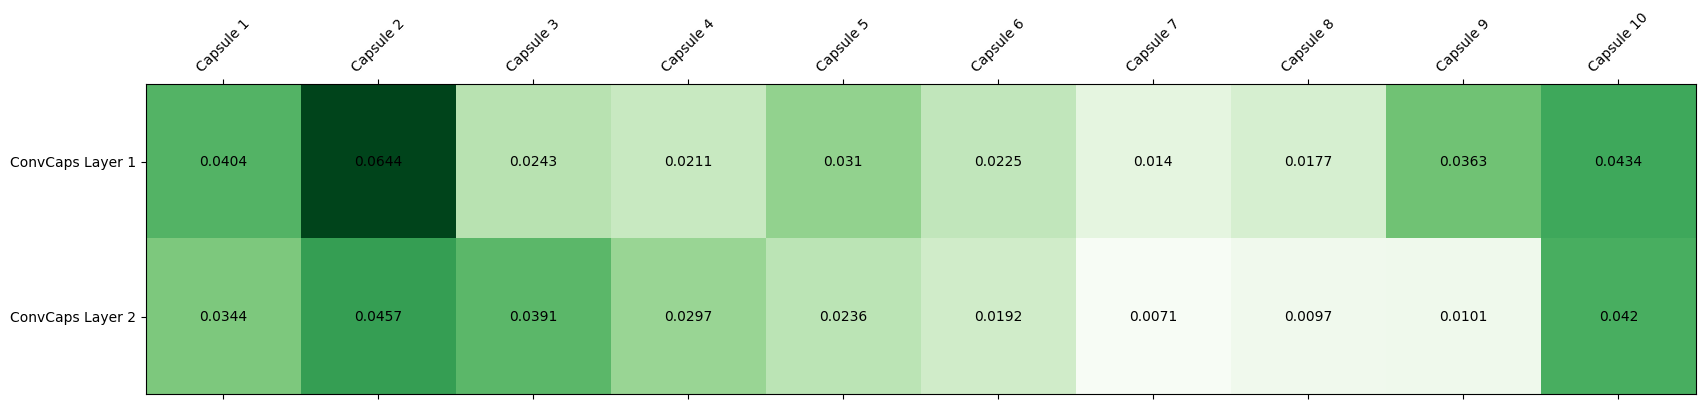

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter2_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

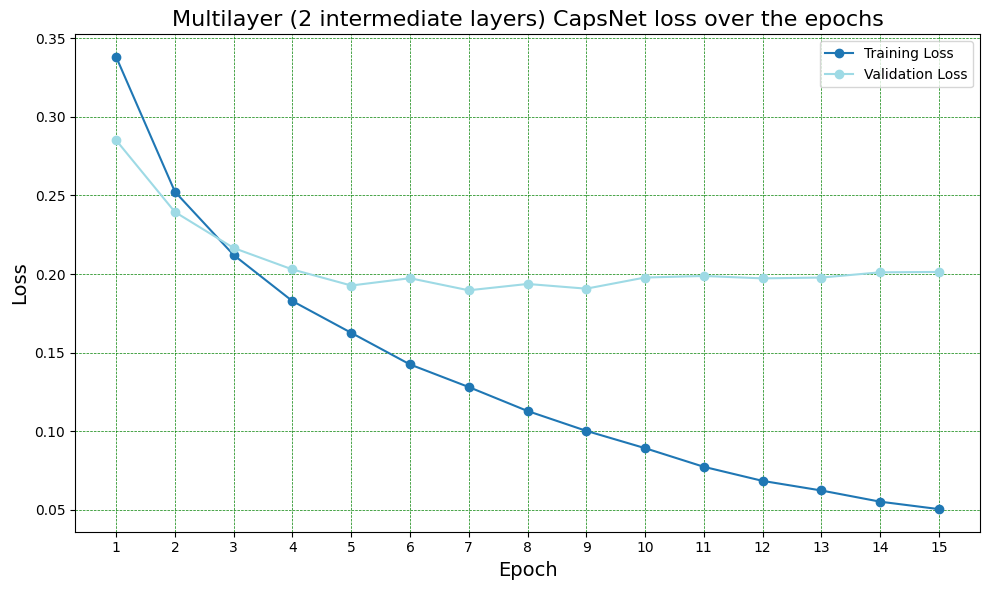

In [ ]:
utils.plot_line_chart(epoch_loss[:, :15], ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (2 intermediate layers) CapsNet loss over the epochs')

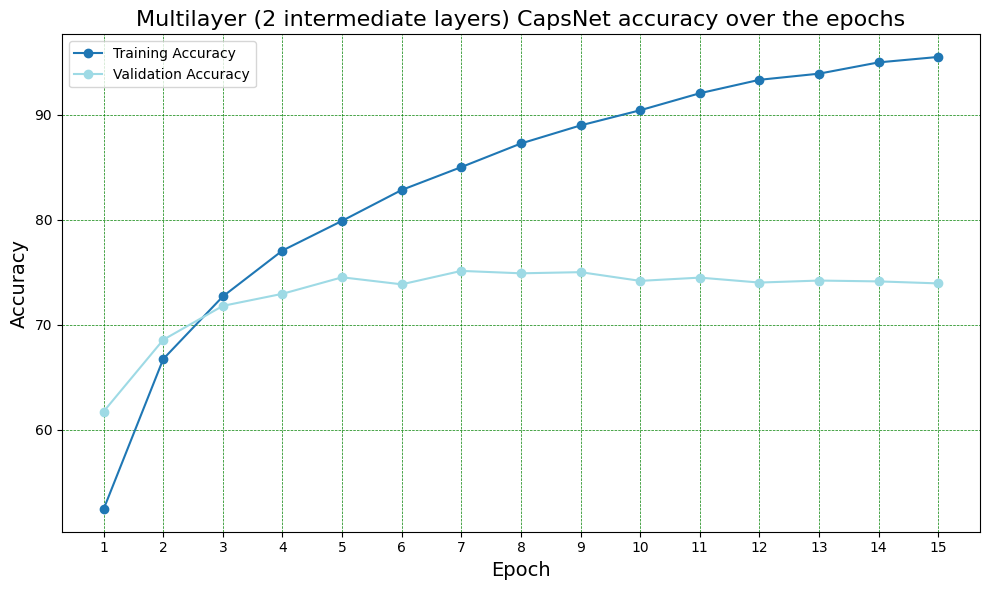

In [ ]:
utils.plot_line_chart(epoch_accuracy[:, :15], ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (2 intermediate layers) CapsNet accuracy over the epochs')

## 3 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=3
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter3_capsnet_cifar10_model.name = 'multilayer_inter3_capsnet_cifar10_model'
multilayer_inter3_capsnet_cifar10_model = multilayer_inter3_capsnet_cifar10_model.to(device)
multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): Caps

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter3_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 05:28:17 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6746, Top 1 Acc=9.38, Top 5 Acc=45.31
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.6746, Top 1 Acc=9.38, Top 5 Acc=45.31
02/05 05:28:35 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4593, Top 1 Acc=30.84, Top 5 Acc=78.39
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4593, Top 1 Acc=30.84, Top 5 Acc=78.39
02/05 05:28:54 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4275, Top 1 Acc=36.74, Top 5 Acc=82.95
INFO:capsnet:multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4275, Top 1 Acc=36.74, Top 5 Acc=82.95
02/05 05:29:12 PM | multilayer_inter3_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4119, Top 1 Acc=39.62, Top 5 Acc=84.89


CPU times: user 56min 5s, sys: 2min 19s, total: 58min 24s
Wall time: 59min


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter3_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter3_capsnet_cifar10_model.pt')

best_multilayer_inter3_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter3_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter3_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter3_capsnet_cifar10_model.name = 'best_multilayer_inter3_capsnet_cifar10_model'
best_multilayer_inter3_capsnet_cifar10_model = best_multilayer_inter3_capsnet_cifar10_model.to(device)
best_multilayer_inter3_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
  )
  (class_caps): Caps

In [ ]:
capsnet_inter3_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter3_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:31:07 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
02/17 02:31:08 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
02/17 02:31:08 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=95.312
02/17 02:31:08 AM | best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter3_capsnet_cifar10_model - Iterations=4/157

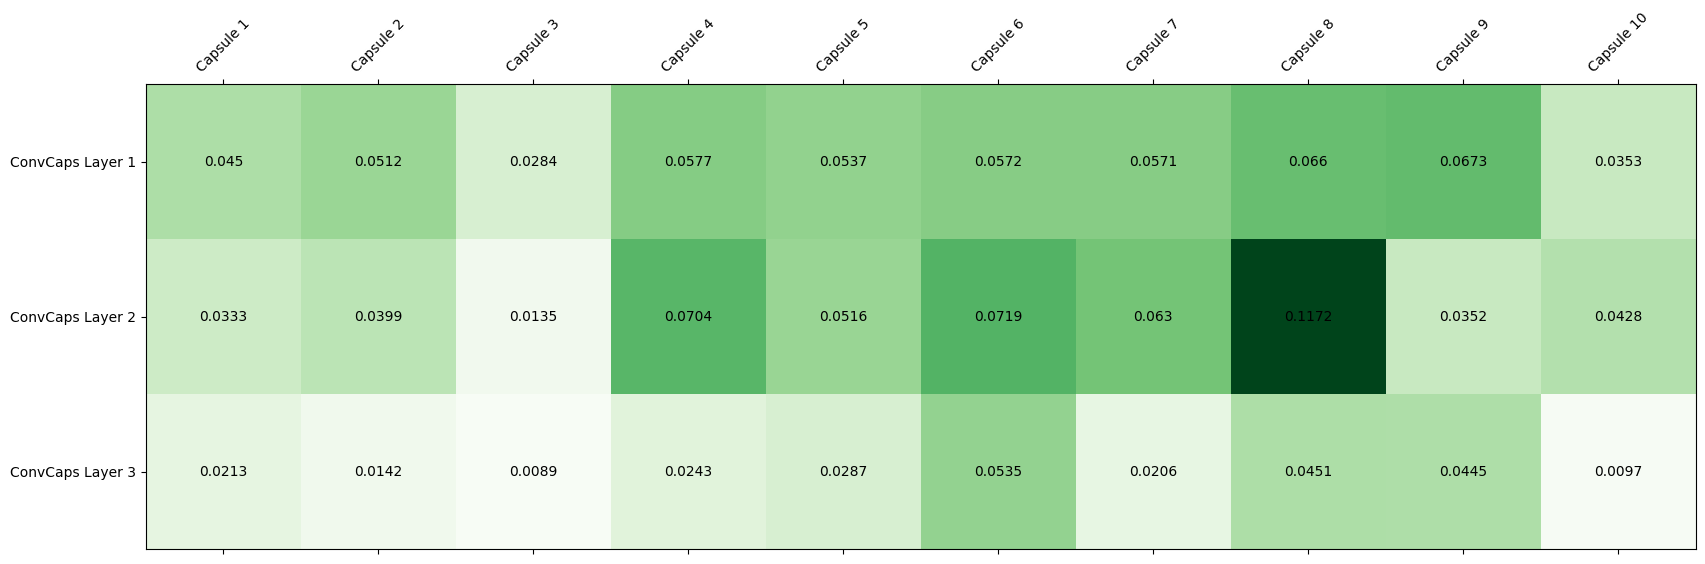

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter3_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

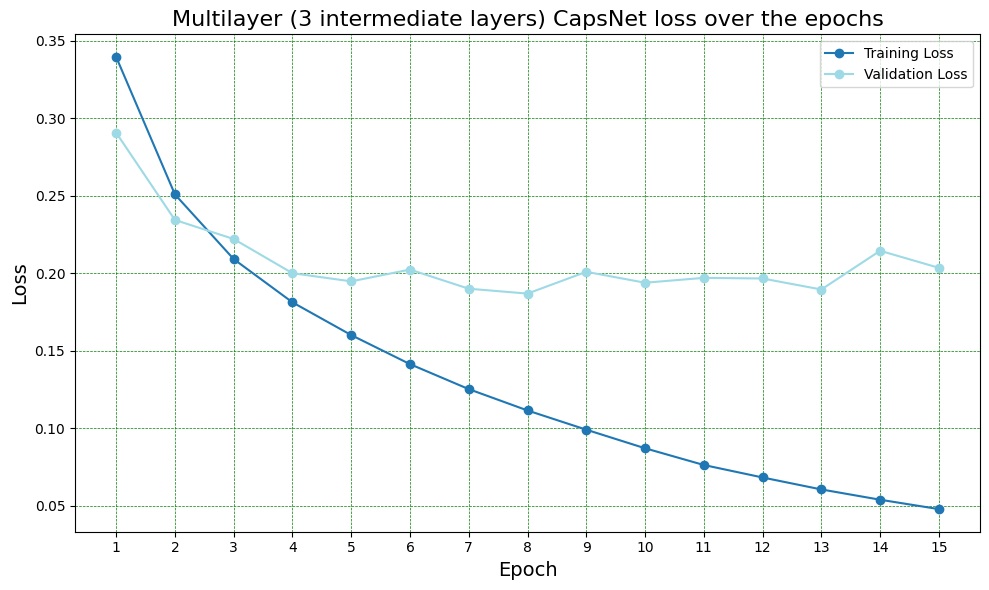

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (3 intermediate layers) CapsNet loss over the epochs')

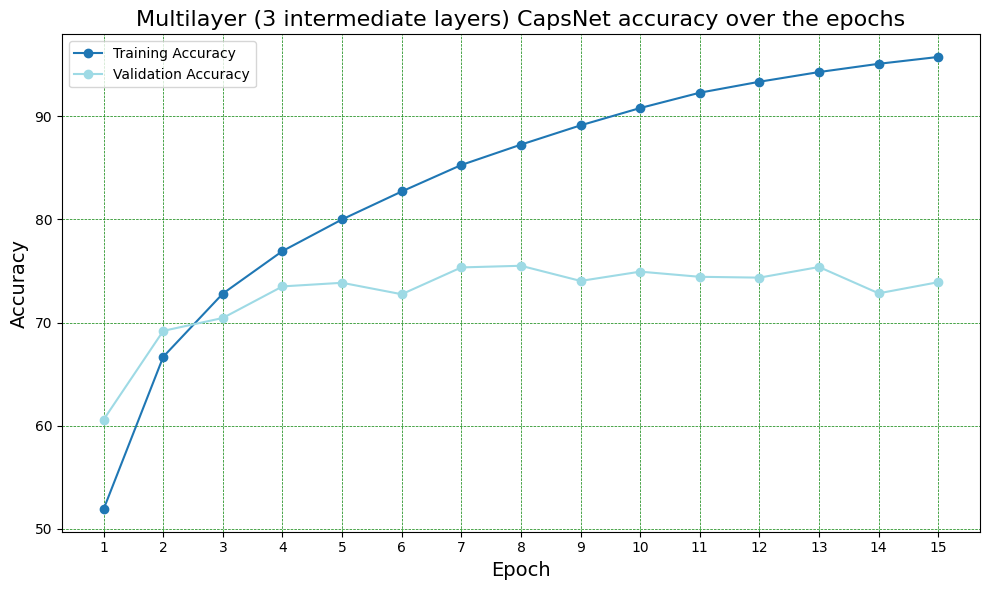

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (3 intermediate layers) CapsNet accuracy over the epochs')

## 4 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=4
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter4_capsnet_cifar10_model.name = 'multilayer_inter4_capsnet_cifar10_model'
multilayer_inter4_capsnet_cifar10_model = multilayer_inter4_capsnet_cifar10_model.to(device)
multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter4_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 06:30:24 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7170, Top 1 Acc=12.50, Top 5 Acc=51.56
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7170, Top 1 Acc=12.50, Top 5 Acc=51.56
02/05 06:30:48 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4521, Top 1 Acc=31.85, Top 5 Acc=80.79
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4521, Top 1 Acc=31.85, Top 5 Acc=80.79
02/05 06:31:11 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4234, Top 1 Acc=36.74, Top 5 Acc=84.70
INFO:capsnet:multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4234, Top 1 Acc=36.74, Top 5 Acc=84.70
02/05 06:31:35 PM | multilayer_inter4_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4066, Top 1 Acc=39.67, Top 5 Acc=86.8

CPU times: user 1h 9min 53s, sys: 2min 51s, total: 1h 12min 45s
Wall time: 1h 13min 20s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter4_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter4_capsnet_cifar10_model.pt')

best_multilayer_inter4_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter4_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter4_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter4_capsnet_cifar10_model.name = 'best_multilayer_inter4_capsnet_cifar10_model'
best_multilayer_inter4_capsnet_cifar10_model = best_multilayer_inter4_capsnet_cifar10_model.to(device)
best_multilayer_inter4_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter4_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter4_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:34:10 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=100.000
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=100.000
02/17 02:34:10 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=99.219
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=99.219
02/17 02:34:10 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.604, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.604, Top 5 Acc=96.875
02/17 02:34:10 AM | best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.172, Top 5 Acc=97.266
INFO:capsnet:best_multilayer_inter4_capsnet_cifar10_model - Iterations=4/1

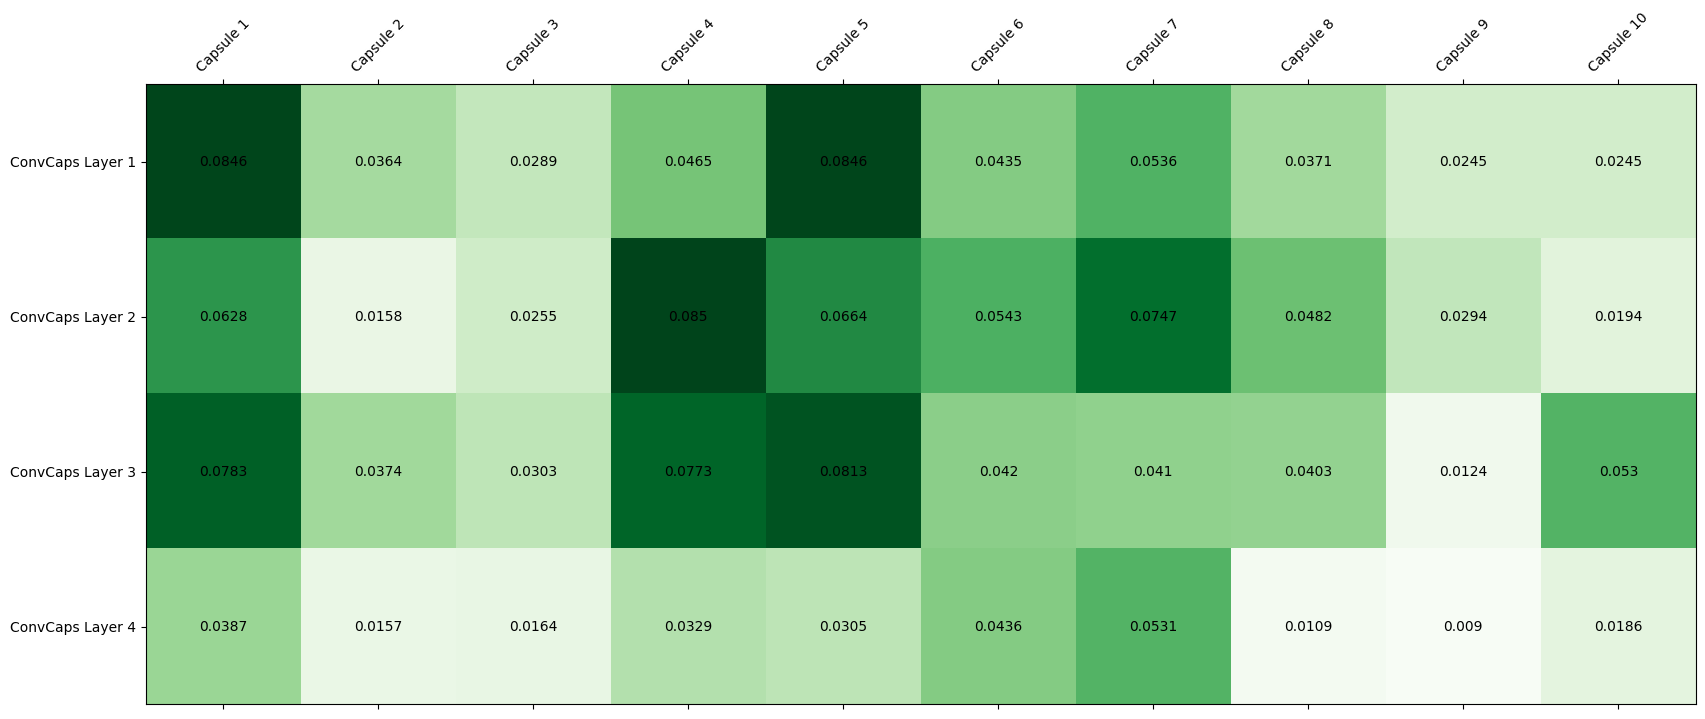

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter4_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

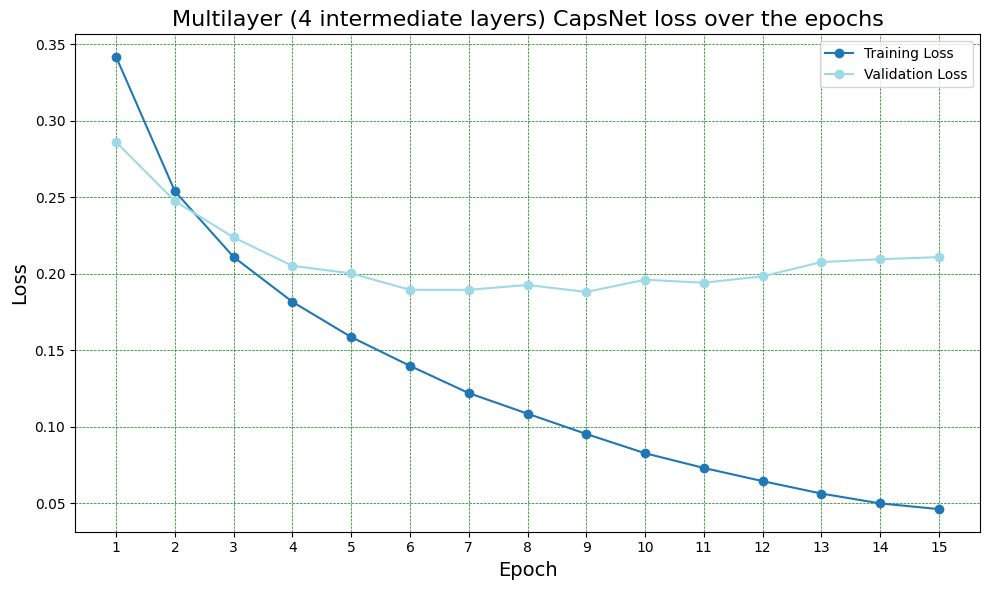

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (4 intermediate layers) CapsNet loss over the epochs')

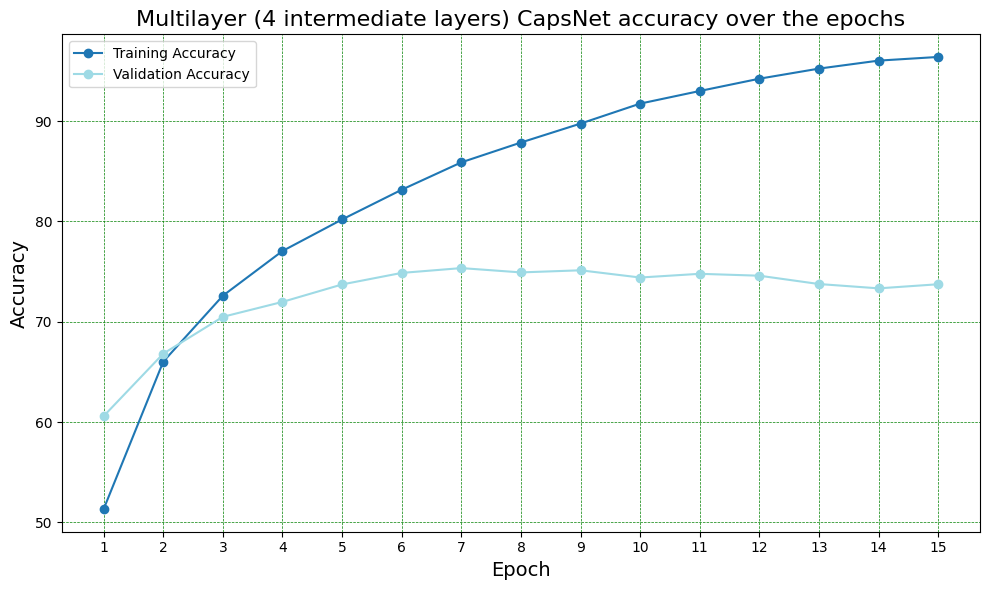

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (4 intermediate layers) CapsNet accuracy over the epochs')

## 5 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=5
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter5_capsnet_cifar10_model.name = 'multilayer_inter5_capsnet_cifar10_model'
multilayer_inter5_capsnet_cifar10_model = multilayer_inter5_capsnet_cifar10_model.to(device)
multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter5_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 07:47:38 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7410, Top 1 Acc=14.06, Top 5 Acc=50.00
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7410, Top 1 Acc=14.06, Top 5 Acc=50.00
02/05 07:48:05 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4580, Top 1 Acc=30.87, Top 5 Acc=79.25
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4580, Top 1 Acc=30.87, Top 5 Acc=79.25
02/05 07:48:33 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4287, Top 1 Acc=36.47, Top 5 Acc=83.43
INFO:capsnet:multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4287, Top 1 Acc=36.47, Top 5 Acc=83.43
02/05 07:49:03 PM | multilayer_inter5_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4121, Top 1 Acc=39.08, Top 5 Acc=85.3

CPU times: user 1h 24min 43s, sys: 3min 25s, total: 1h 28min 9s
Wall time: 1h 28min 51s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter5_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter5_capsnet_cifar10_model.pt')

best_multilayer_inter5_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter5_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter5_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter5_capsnet_cifar10_model.name = 'best_multilayer_inter5_capsnet_cifar10_model'
best_multilayer_inter5_capsnet_cifar10_model = best_multilayer_inter5_capsnet_cifar10_model.to(device)
best_multilayer_inter5_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter5_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter5_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:35:14 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=96.875
02/17 02:35:14 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=97.656
02/17 02:35:14 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.042, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.042, Top 5 Acc=96.875
02/17 02:35:14 AM | best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.172, Top 5 Acc=96.484
INFO:capsnet:best_multilayer_inter5_capsnet_cifar10_model - Iterations=4/157

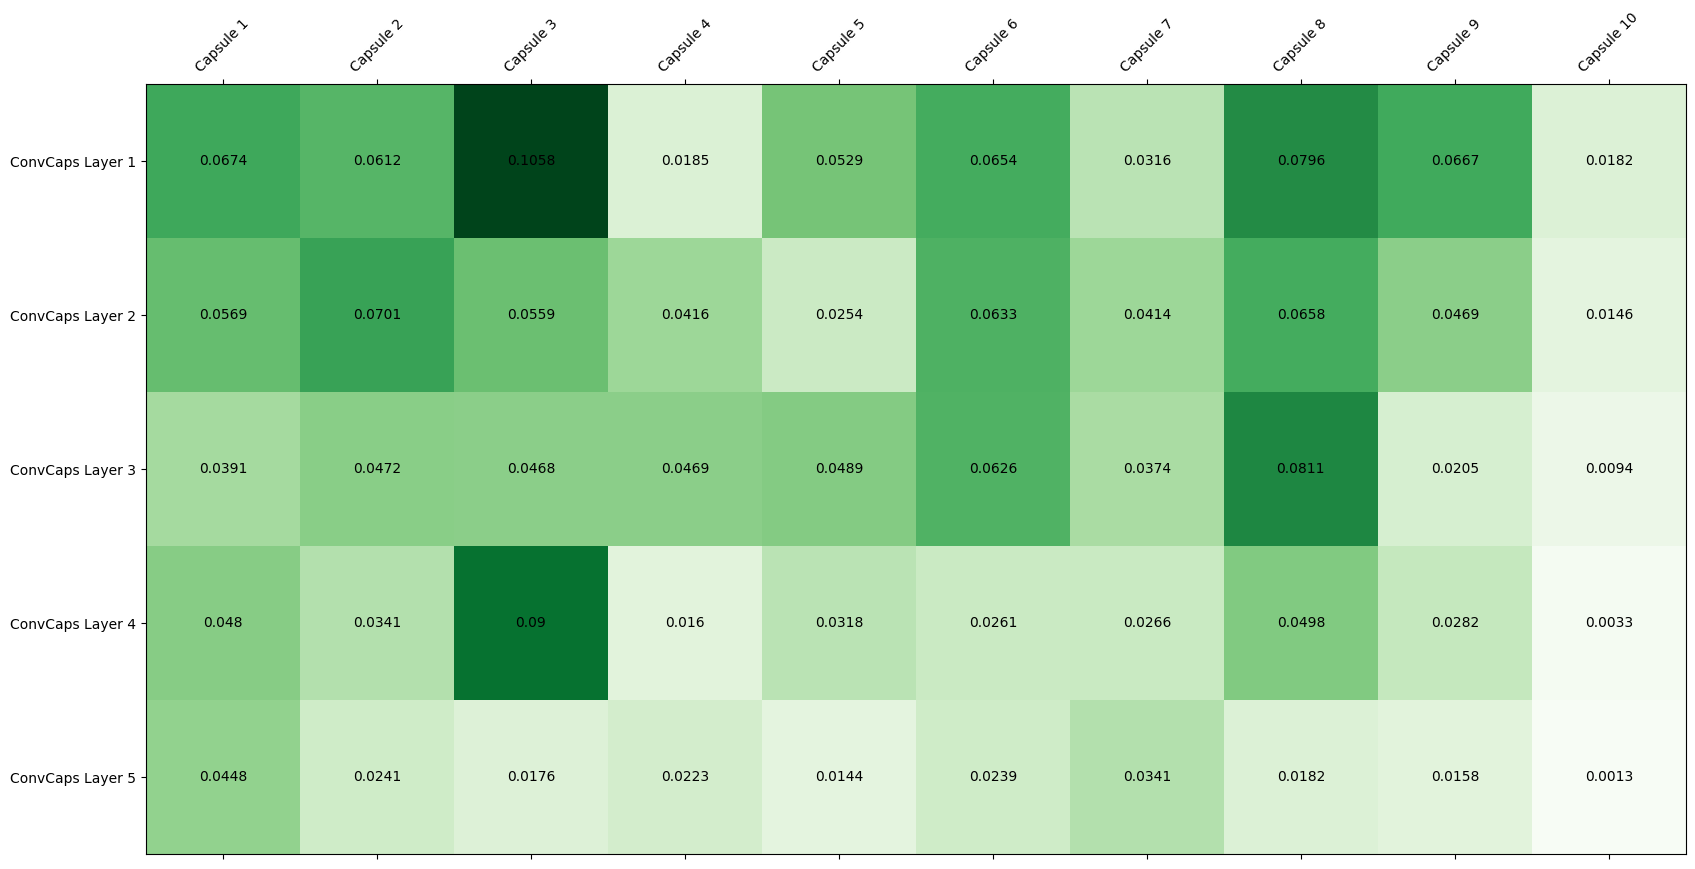

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter5_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

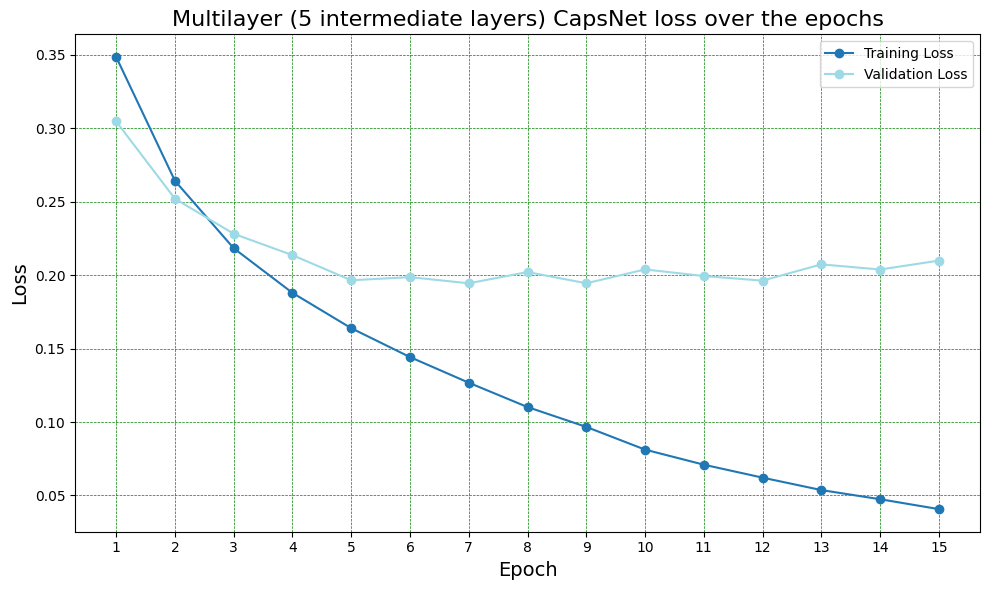

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (5 intermediate layers) CapsNet loss over the epochs')

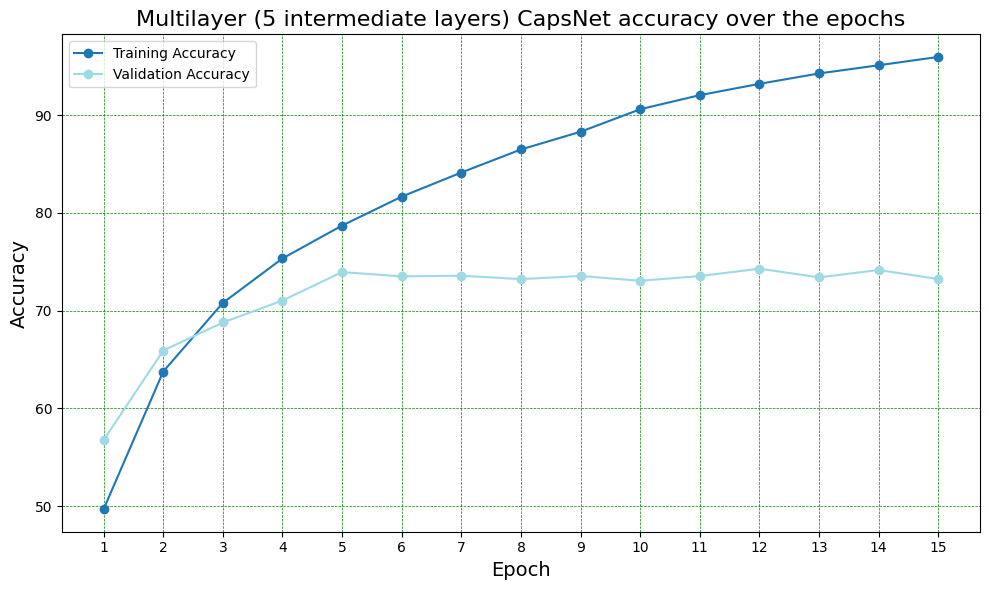

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (5 intermediate layers) CapsNet accuracy over the epochs')

## 6 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=6
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter6_capsnet_cifar10_model.name = 'multilayer_inter6_capsnet_cifar10_model'
multilayer_inter6_capsnet_cifar10_model = multilayer_inter6_capsnet_cifar10_model.to(device)
multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter6_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 09:17:52 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7525, Top 1 Acc=10.94, Top 5 Acc=53.12
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7525, Top 1 Acc=10.94, Top 5 Acc=53.12
02/05 09:18:26 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4693, Top 1 Acc=28.92, Top 5 Acc=77.64
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4693, Top 1 Acc=28.92, Top 5 Acc=77.64
02/05 09:18:59 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4352, Top 1 Acc=35.04, Top 5 Acc=82.63
INFO:capsnet:multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4352, Top 1 Acc=35.04, Top 5 Acc=82.63
02/05 09:19:32 PM | multilayer_inter6_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4183, Top 1 Acc=37.95, Top 5 Acc=84.5

CPU times: user 1h 40min 9s, sys: 4min 2s, total: 1h 44min 11s
Wall time: 1h 45min 3s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter6_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter6_capsnet_cifar10_model.pt')

best_multilayer_inter6_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter6_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter6_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter6_capsnet_cifar10_model.name = 'best_multilayer_inter6_capsnet_cifar10_model'
best_multilayer_inter6_capsnet_cifar10_model = best_multilayer_inter6_capsnet_cifar10_model.to(device)
best_multilayer_inter6_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter6_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter6_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:36:09 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=93.750
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=71.875, Top 5 Acc=93.750
02/17 02:36:10 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=94.531
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=94.531
02/17 02:36:10 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.521, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.521, Top 5 Acc=95.312
02/17 02:36:10 AM | best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.172, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter6_capsnet_cifar10_model - Iterations=4/157

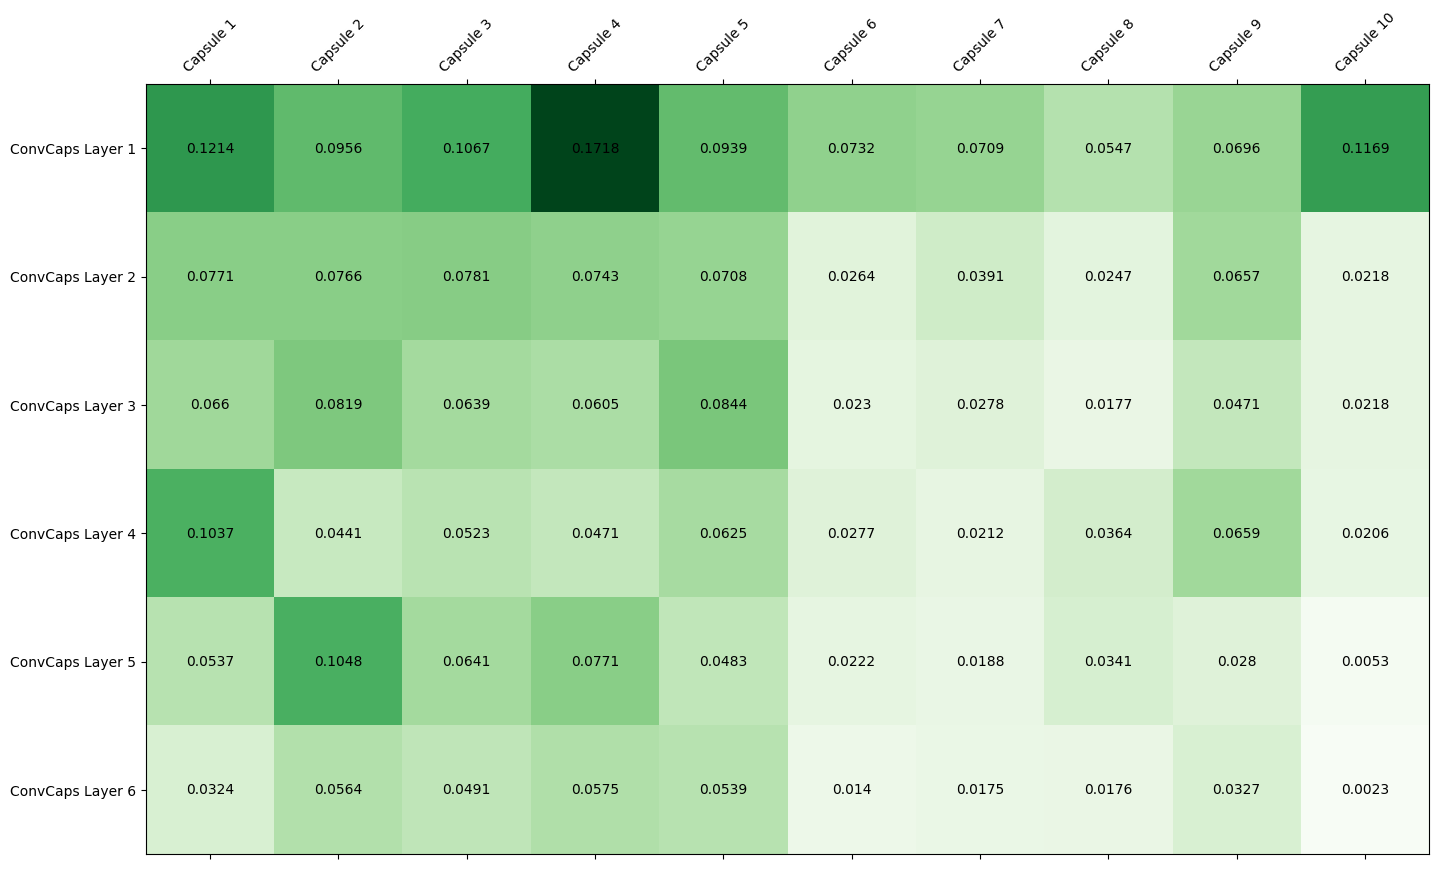

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter6_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

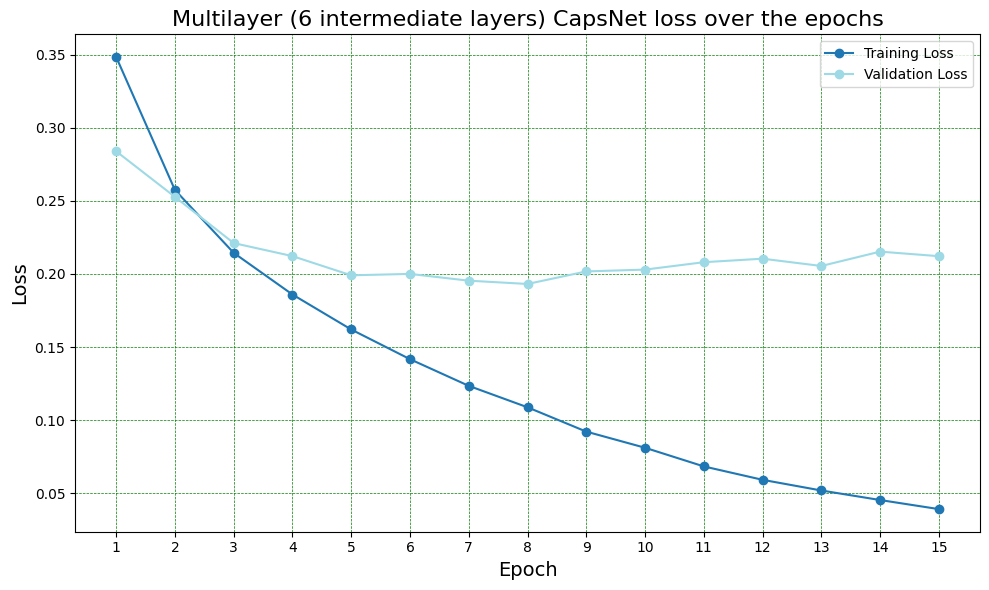

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (6 intermediate layers) CapsNet loss over the epochs')

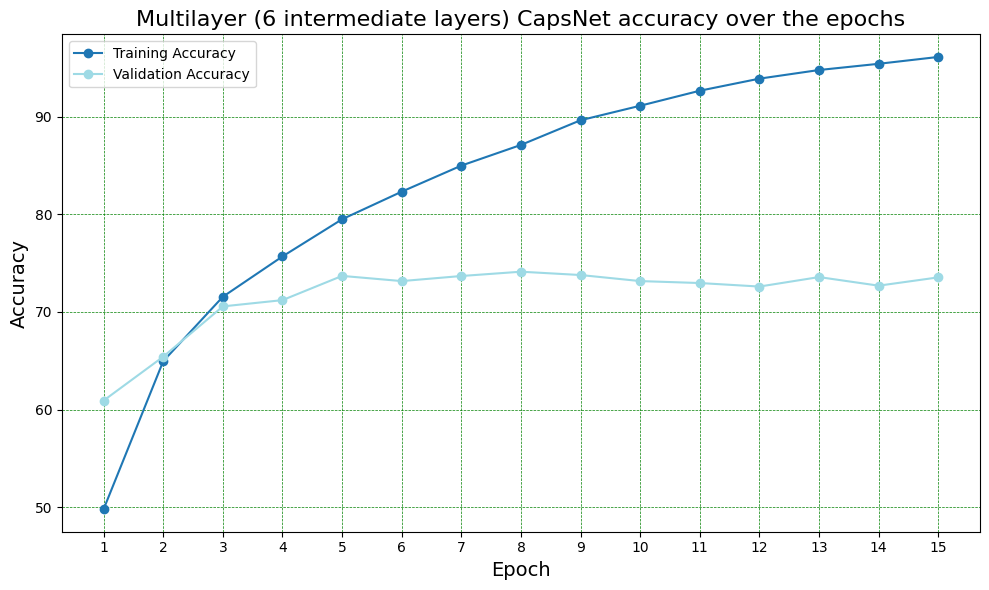

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (6 intermediate layers) CapsNet accuracy over the epochs')

## 7 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=7
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter7_capsnet_cifar10_model.name = 'multilayer_inter7_capsnet_cifar10_model'
multilayer_inter7_capsnet_cifar10_model = multilayer_inter7_capsnet_cifar10_model.to(device)
multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter7_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/05 11:02:58 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7561, Top 1 Acc=9.38, Top 5 Acc=42.19
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7561, Top 1 Acc=9.38, Top 5 Acc=42.19
02/05 11:03:37 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4733, Top 1 Acc=29.42, Top 5 Acc=75.58
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4733, Top 1 Acc=29.42, Top 5 Acc=75.58
02/05 11:04:15 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4375, Top 1 Acc=35.44, Top 5 Acc=81.12
INFO:capsnet:multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4375, Top 1 Acc=35.44, Top 5 Acc=81.12
02/05 11:04:54 PM | multilayer_inter7_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4200, Top 1 Acc=38.19, Top 5 Acc=83.54


CPU times: user 1h 56min 48s, sys: 4min 39s, total: 2h 1min 27s
Wall time: 2h 2min 16s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter7_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter7_capsnet_cifar10_model.pt')

best_multilayer_inter7_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter7_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter7_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter7_capsnet_cifar10_model.name = 'best_multilayer_inter7_capsnet_cifar10_model'
best_multilayer_inter7_capsnet_cifar10_model = best_multilayer_inter7_capsnet_cifar10_model.to(device)
best_multilayer_inter7_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter7_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter7_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:37:40 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
02/17 02:37:40 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=82.812, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=82.812, Top 5 Acc=97.656
02/17 02:37:40 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=81.250, Top 5 Acc=97.396
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=81.250, Top 5 Acc=97.396
02/17 02:37:40 AM | best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=79.297, Top 5 Acc=97.266
INFO:capsnet:best_multilayer_inter7_capsnet_cifar10_model - Iterations=4/157

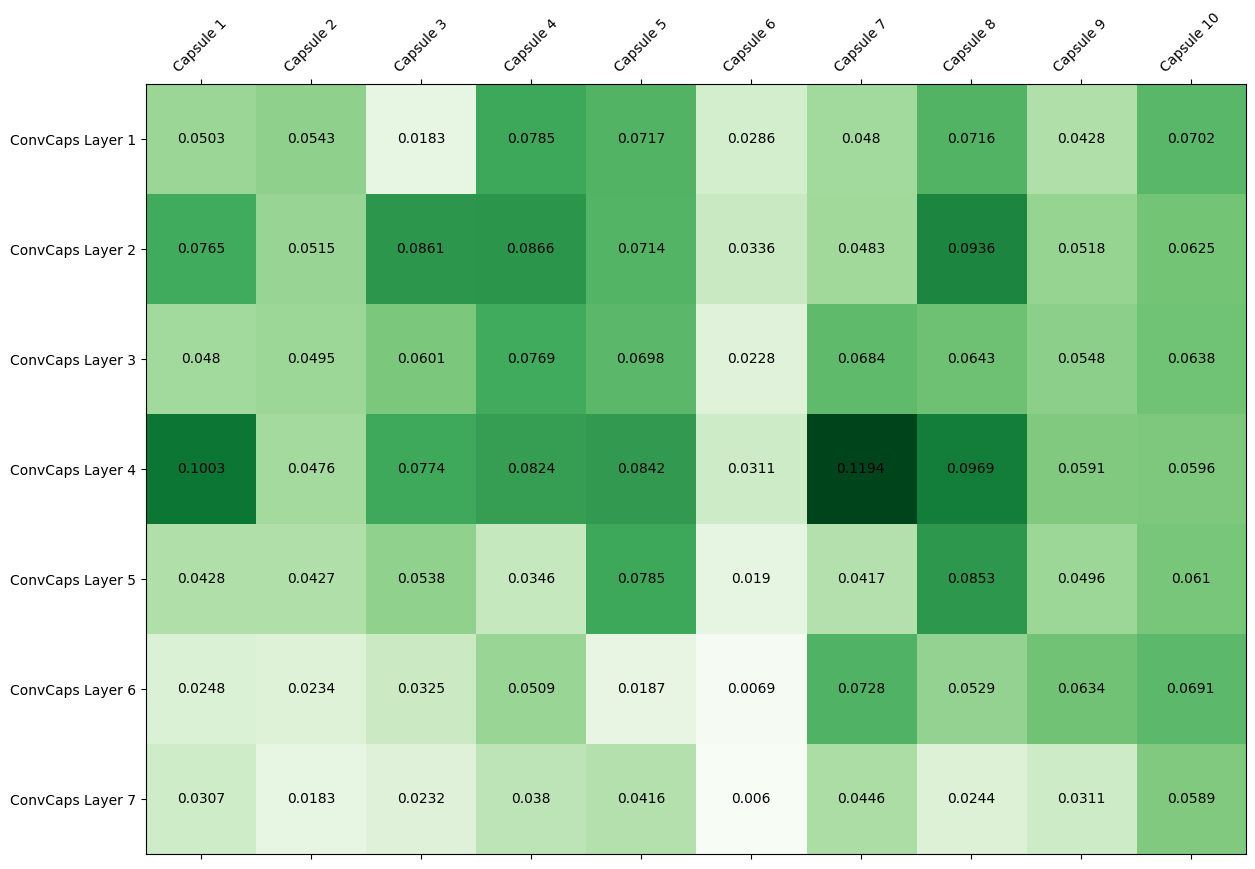

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter7_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

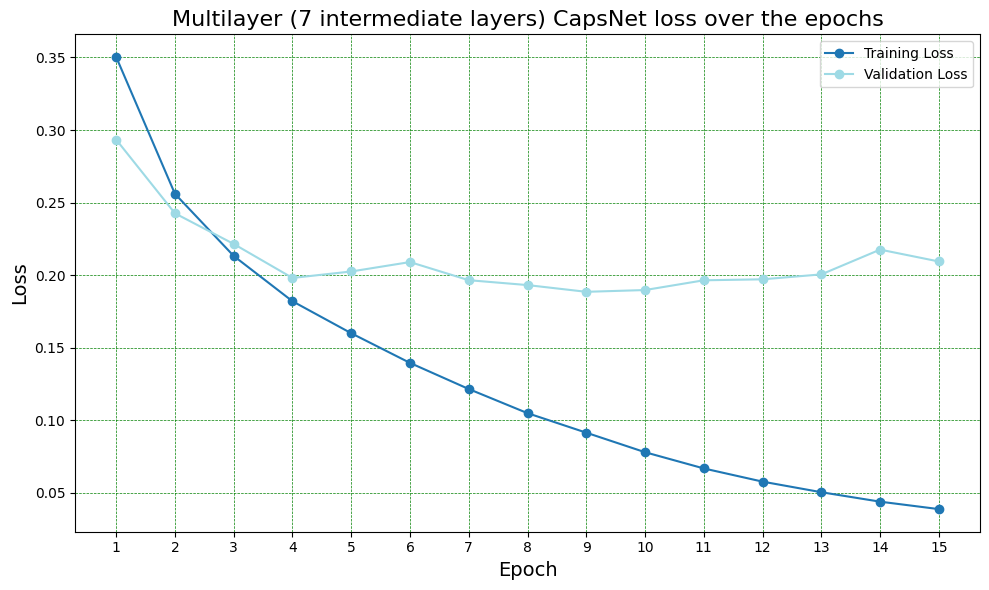

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (7 intermediate layers) CapsNet loss over the epochs')

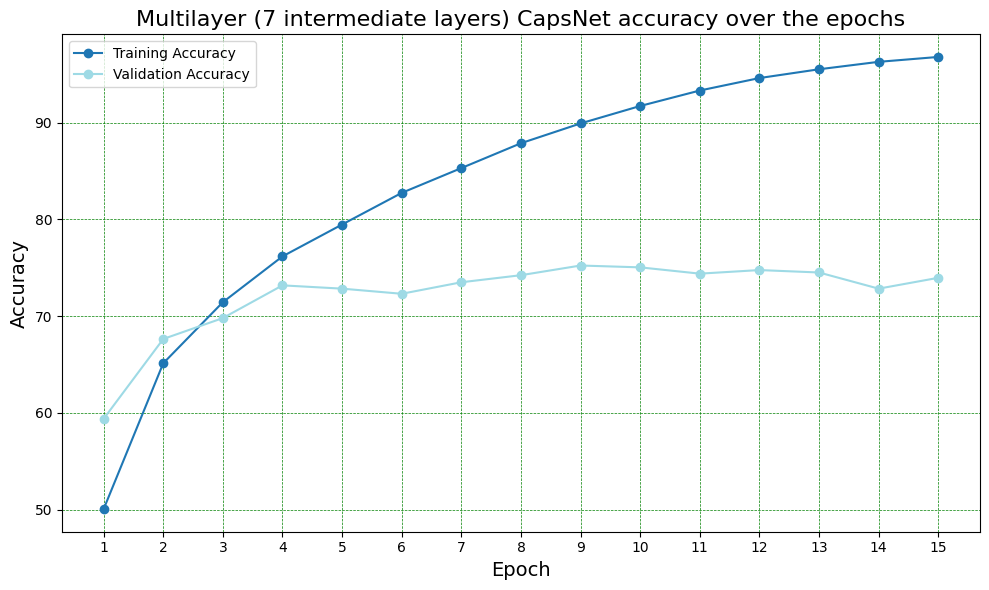

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (7 intermediate layers) CapsNet accuracy over the epochs')

## 8 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=8
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter8_capsnet_cifar10_model.name = 'multilayer_inter8_capsnet_cifar10_model'
multilayer_inter8_capsnet_cifar10_model = multilayer_inter8_capsnet_cifar10_model.to(device)
multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter8_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/06 01:16:19 AM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7934, Top 1 Acc=9.38, Top 5 Acc=64.06
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7934, Top 1 Acc=9.38, Top 5 Acc=64.06
02/06 01:16:47 AM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4694, Top 1 Acc=29.98, Top 5 Acc=77.33
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4694, Top 1 Acc=29.98, Top 5 Acc=77.33
02/06 01:17:12 AM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4409, Top 1 Acc=34.81, Top 5 Acc=81.43
INFO:capsnet:multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4409, Top 1 Acc=34.81, Top 5 Acc=81.43
02/06 01:17:37 AM | multilayer_inter8_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4221, Top 1 Acc=37.62, Top 5 Acc=83.89


CPU times: user 1h 14min 16s, sys: 5min 15s, total: 1h 19min 32s
Wall time: 1h 20min 19s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter8_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter8_capsnet_cifar10_model.pt')

best_multilayer_inter8_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter8_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter8_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter8_capsnet_cifar10_model.name = 'best_multilayer_inter8_capsnet_cifar10_model'
best_multilayer_inter8_capsnet_cifar10_model = best_multilayer_inter8_capsnet_cifar10_model.to(device)
best_multilayer_inter8_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter8_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter8_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:38:52 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
02/17 02:38:52 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=97.656
02/17 02:38:52 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.833
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.833
02/17 02:38:52 AM | best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=76.953, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter8_capsnet_cifar10_model - Iterations=4/157

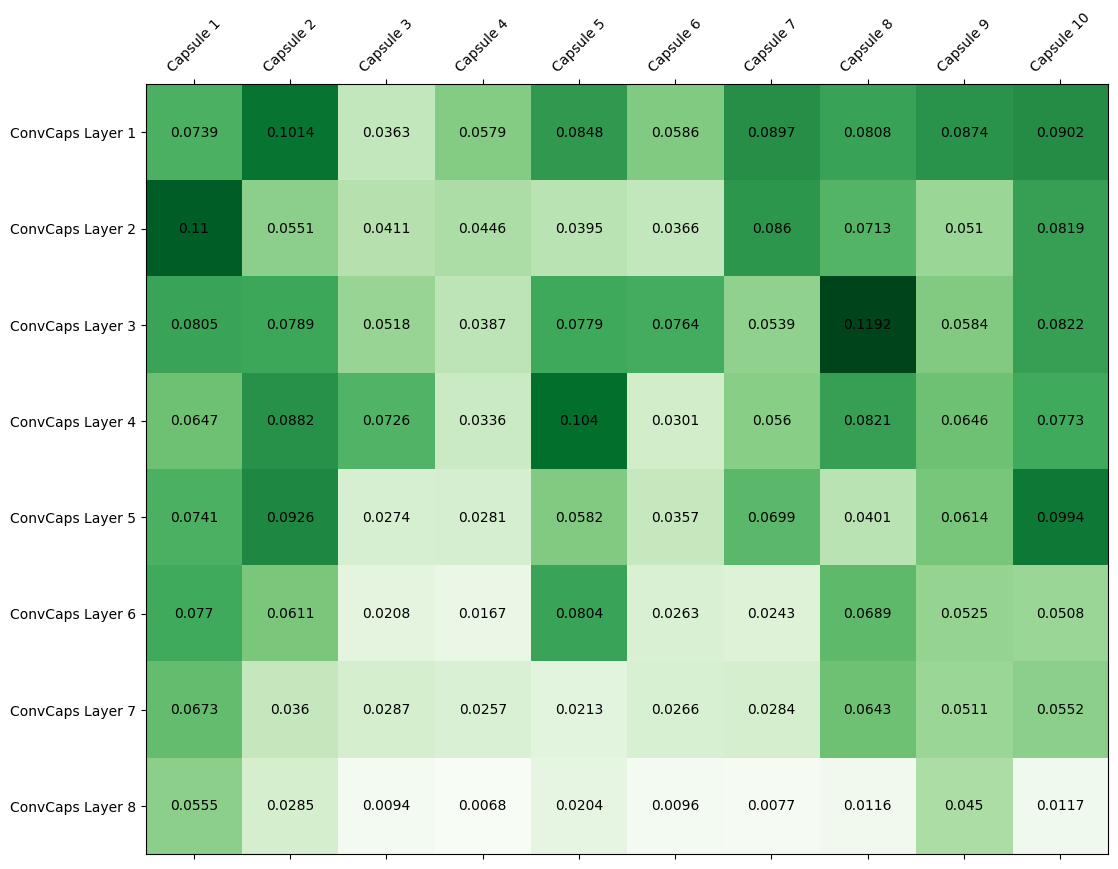

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter8_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

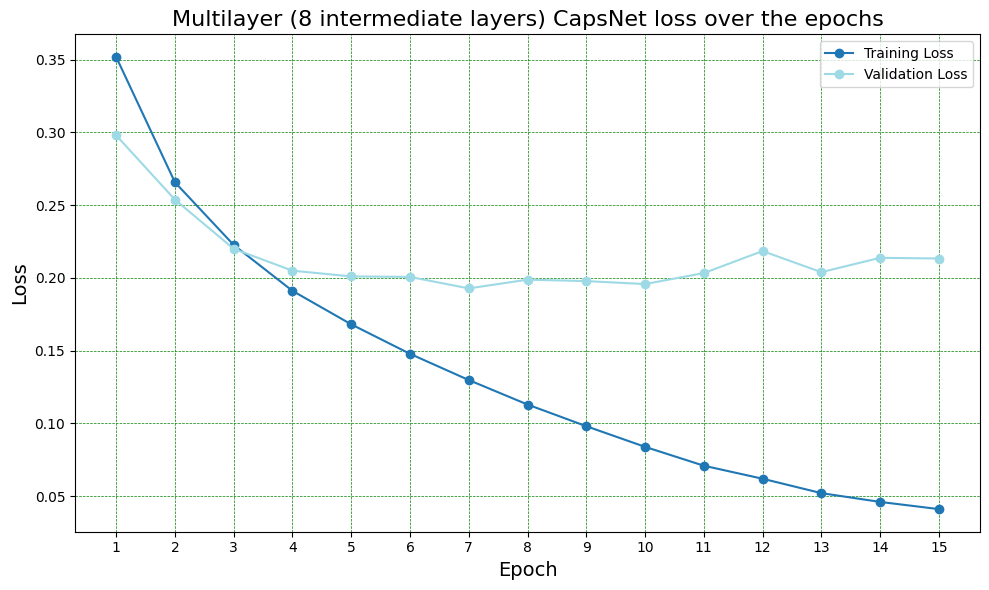

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (8 intermediate layers) CapsNet loss over the epochs')

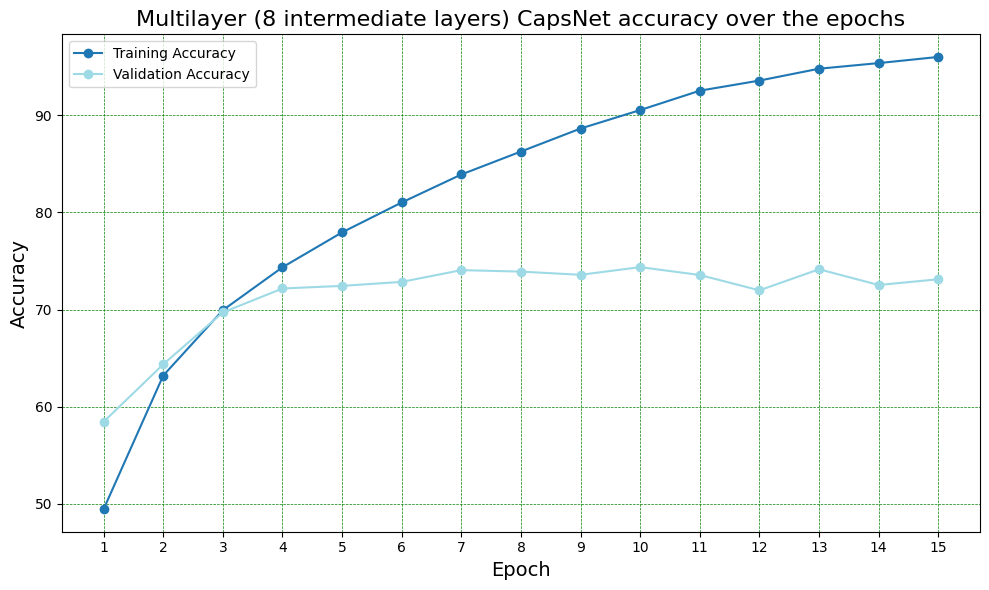

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (8 intermediate layers) CapsNet accuracy over the epochs')

## 9 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=9
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter9_capsnet_cifar10_model.name = 'multilayer_inter9_capsnet_cifar10_model'
multilayer_inter9_capsnet_cifar10_model = multilayer_inter9_capsnet_cifar10_model.to(device)
multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter9_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/06 02:36:40 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7756, Top 1 Acc=10.94, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7756, Top 1 Acc=10.94, Top 5 Acc=59.38
02/06 02:37:09 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4863, Top 1 Acc=26.73, Top 5 Acc=73.61
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4863, Top 1 Acc=26.73, Top 5 Acc=73.61
02/06 02:37:37 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4549, Top 1 Acc=31.90, Top 5 Acc=79.18
INFO:capsnet:multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4549, Top 1 Acc=31.90, Top 5 Acc=79.18
02/06 02:38:05 AM | multilayer_inter9_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4334, Top 1 Acc=35.65, Top 5 Acc=82.2

CPU times: user 1h 23min 25s, sys: 5min 43s, total: 1h 29min 9s
Wall time: 1h 29min 45s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter9_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter9_capsnet_cifar10_model.pt')

best_multilayer_inter9_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                   model_conv_config=model_conv_config,
                                                                   prim_caps_channels=prim_caps_channels,
                                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter9_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter9_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter9_capsnet_cifar10_model.name = 'best_multilayer_inter9_capsnet_cifar10_model'
best_multilayer_inter9_capsnet_cifar10_model = best_multilayer_inter9_capsnet_cifar10_model.to(device)
best_multilayer_inter9_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter9_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter9_capsnet_cifar10_model,
                                                                         test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 02:41:03 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=79.688, Top 5 Acc=96.875
02/17 02:41:03 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=98.438
02/17 02:41:03 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=98.438
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=98.438
02/17 02:41:03 AM | best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=72.656, Top 5 Acc=98.047
INFO:capsnet:best_multilayer_inter9_capsnet_cifar10_model - Iterations=4/157

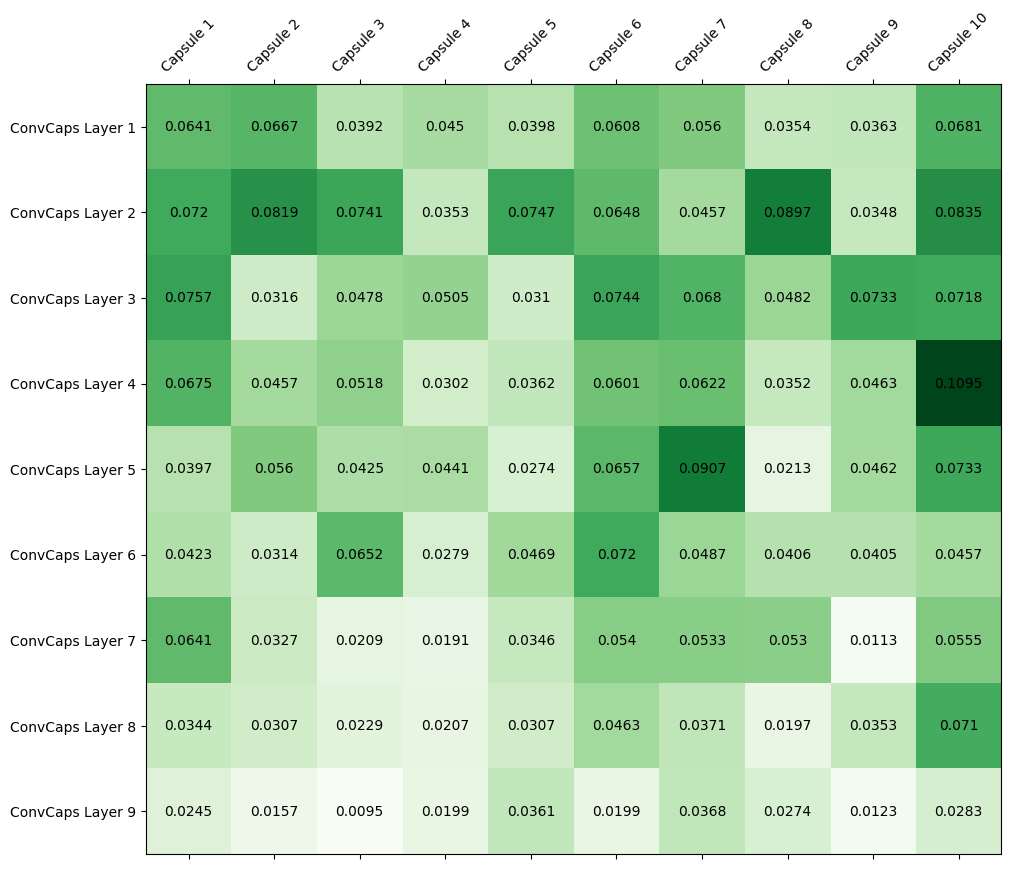

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter9_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

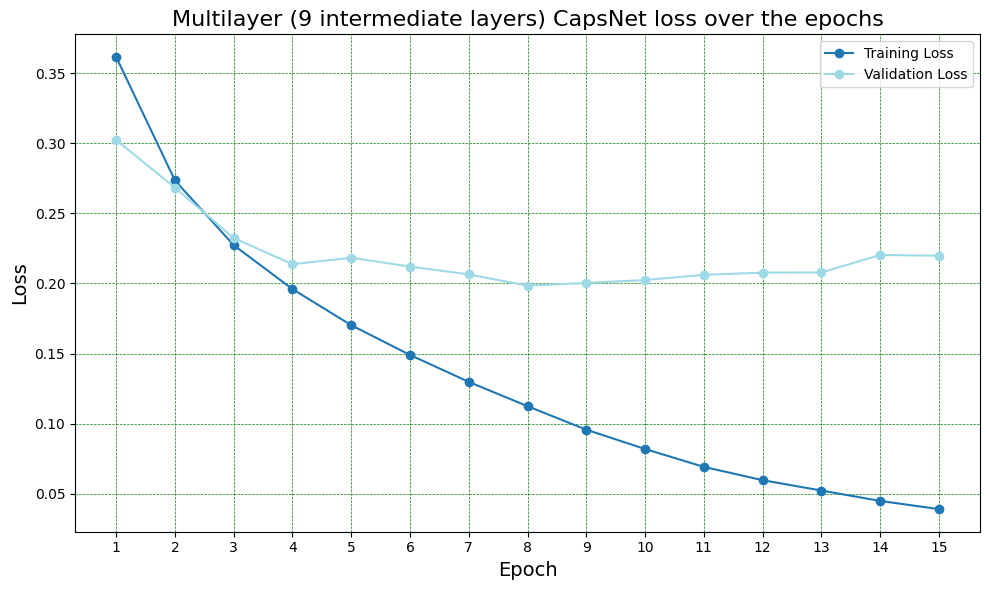

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (9 intermediate layers) CapsNet loss over the epochs')

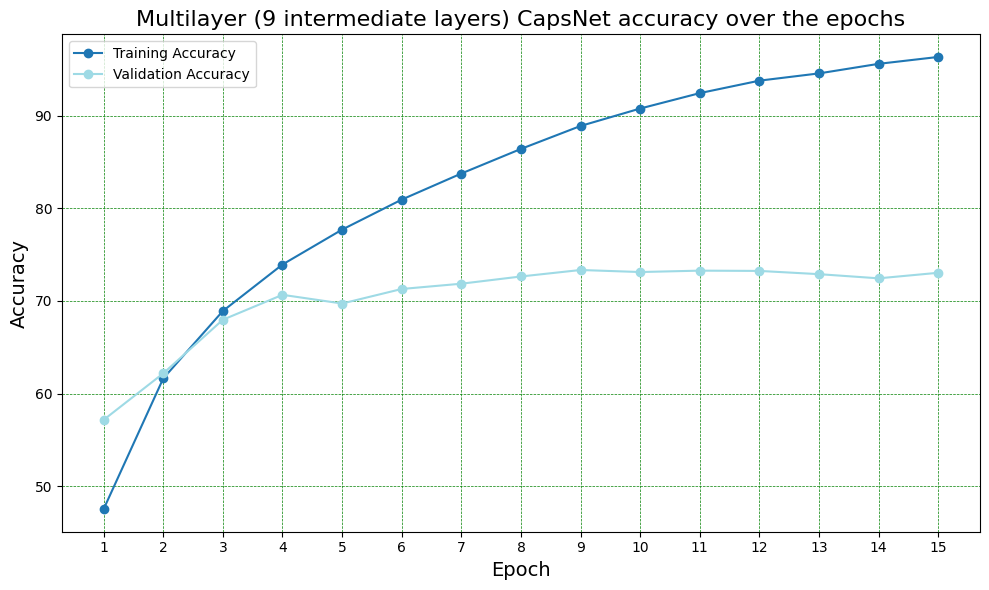

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (9 intermediate layers) CapsNet accuracy over the epochs')

In [ ]:
# from google.colab import runtime
# runtime.unassign()

## 10 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=10
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:01<00:00, 98858554.97it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.name = 'multilayer_inter10_capsnet_cifar10_model'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter10_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

02/17 02:50:23 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7908, Top 1 Acc=4.69, Top 5 Acc=62.50
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7908, Top 1 Acc=4.69, Top 5 Acc=62.50
02/17 02:50:49 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4816, Top 1 Acc=26.85, Top 5 Acc=75.22
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4816, Top 1 Acc=26.85, Top 5 Acc=75.22
02/17 02:51:16 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4500, Top 1 Acc=32.85, Top 5 Acc=79.81
INFO:capsnet:multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4500, Top 1 Acc=32.85, Top 5 Acc=79.81
02/17 02:51:42 AM | multilayer_inter10_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4296, Top 1 Acc=36.56, Top 5 Acc

CPU times: user 1h 17min 47s, sys: 5min 29s, total: 1h 23min 17s
Wall time: 1h 23min 8s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter10_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter10_capsnet_cifar10_model.pt')

best_multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter10_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter10_capsnet_cifar10_model.name = 'best_multilayer_inter10_capsnet_cifar10_model'
best_multilayer_inter10_capsnet_cifar10_model = best_multilayer_inter10_capsnet_cifar10_model.to(device)
best_multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter10_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter10_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

02/17 04:13:29 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=76.562, Top 5 Acc=95.312
02/17 04:13:29 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=96.875
02/17 04:13:29 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.083, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=77.083, Top 5 Acc=95.312
02/17 04:13:29 AM | best_multilayer_inter10_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=94.531
INFO:capsnet:best_multilayer_inter10_capsnet_cifar10_model - Iteratio

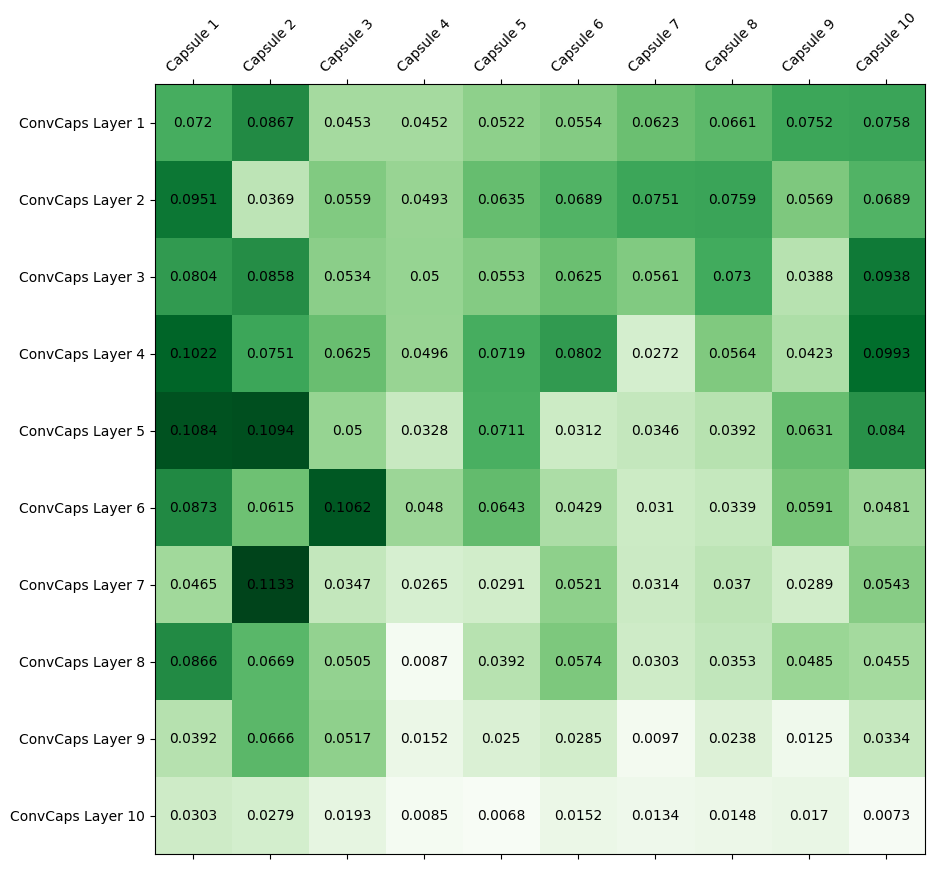

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter10_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 1

In [ ]:
trained_inter10_capsnet_model_epoch1 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch1_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config,
                                                               prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch1['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch1'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
epoch1_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:13:23 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=64.062, Top 5 Acc=89.062
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=64.062, Top 5 Acc=89.062
03/02 07:13:23 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=63.281, Top 5 Acc=89.844
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=63.281, Top 5 Acc=89.844
03/02 07:13:23 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=60.417, Top 5 Acc=91.667
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=60.417, Top 5 Acc=91.667
03/02 07:13:23 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch1 - Iterations=4/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=93.359

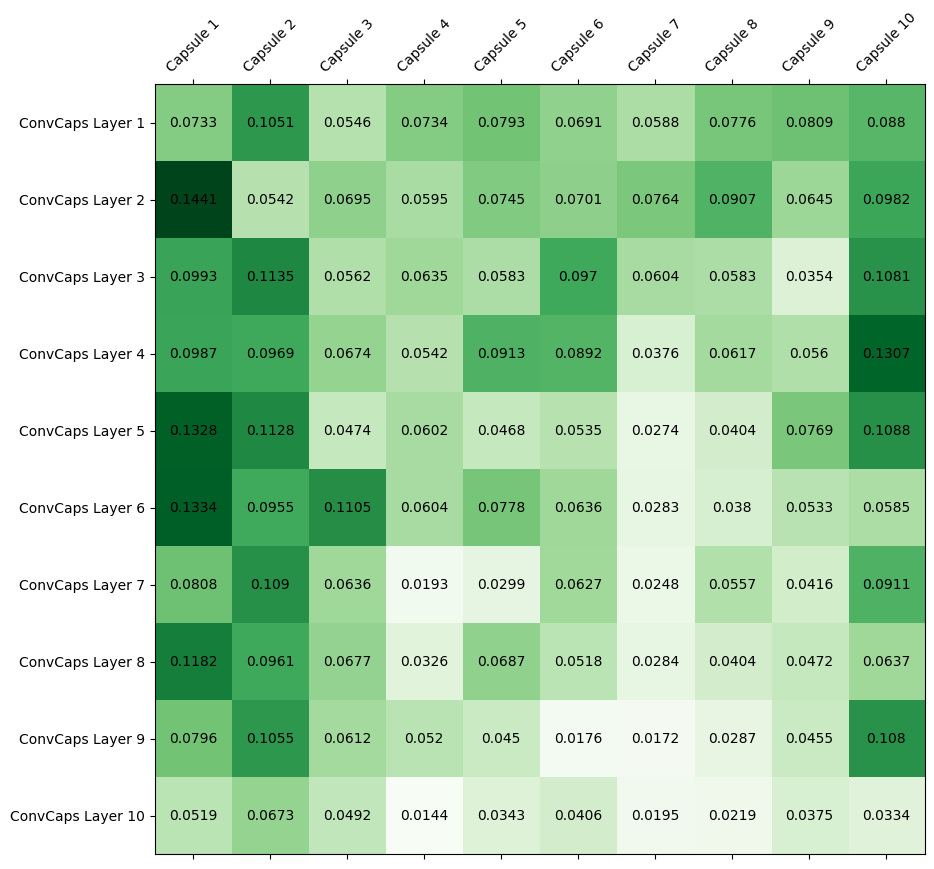

In [ ]:
utils.plot_caps_layers_activations(epoch1_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

ConvCaps Activation for Epoch 15

In [ ]:
trained_inter10_capsnet_model_epoch15 = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

multilayer_inter10_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter10_capsnet_cifar10_model.load_state_dict(trained_inter10_capsnet_model_epoch15['model_state_dict'])

multilayer_inter10_capsnet_cifar10_model.name = 'trained_multilayer_inter10_capsnet_cifar10_model_epoch15'
multilayer_inter10_capsnet_cifar10_model = multilayer_inter10_capsnet_cifar10_model.to(device)
multilayer_inter10_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
epoch15_convcaps_activations = utils.extract_convcaps_activations(multilayer_inter10_capsnet_cifar10_model,
                                                                  test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/02 07:13:53 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=93.750
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=1/157, Batch Size=64, Top 1 Acc=78.125, Top 5 Acc=93.750
03/02 07:13:53 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=93.750
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=2/157, Batch Size=64, Top 1 Acc=75.781, Top 5 Acc=93.750
03/02 07:13:54 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
03/02 07:13:54 PM | trained_multilayer_inter10_capsnet_cifar10_model_epoch15 - Iterations=4/157, Batch Size=64, Top 1 Acc=74.219, Top 5 Acc

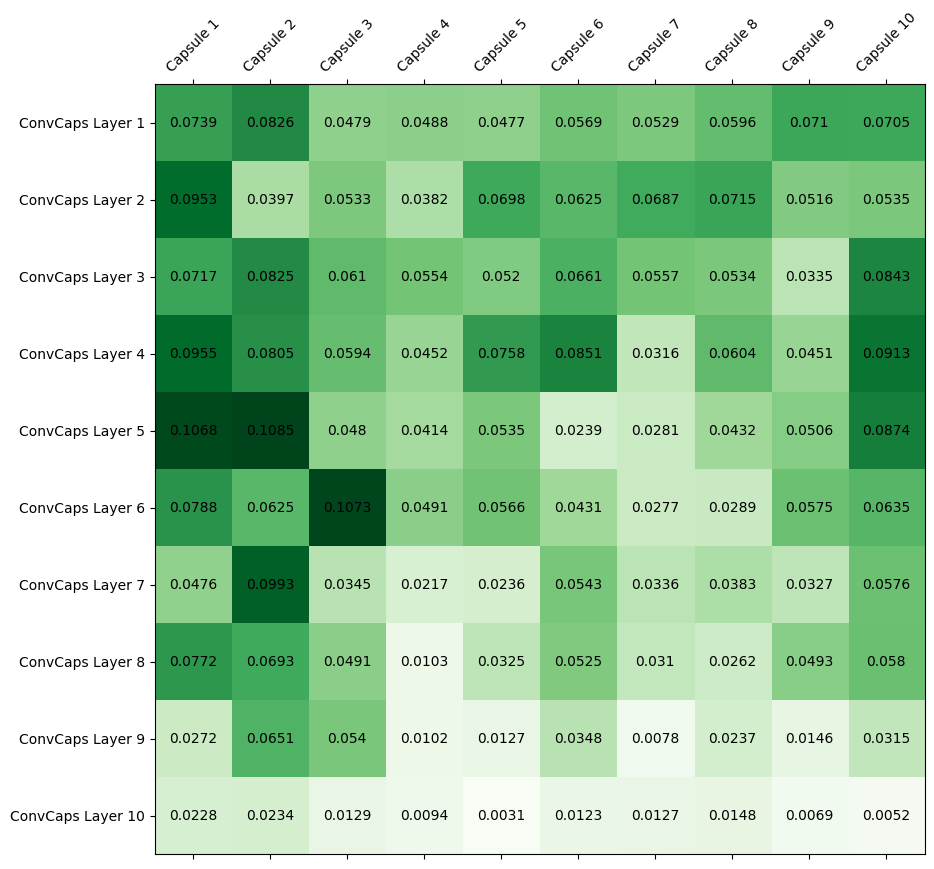

In [ ]:
utils.plot_caps_layers_activations(epoch15_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

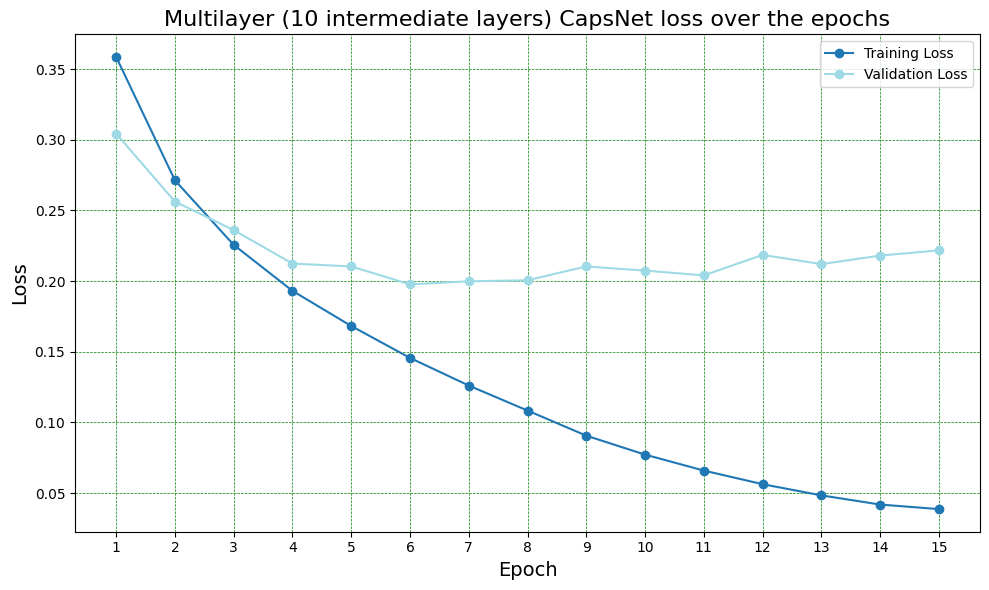

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (10 intermediate layers) CapsNet loss over the epochs')

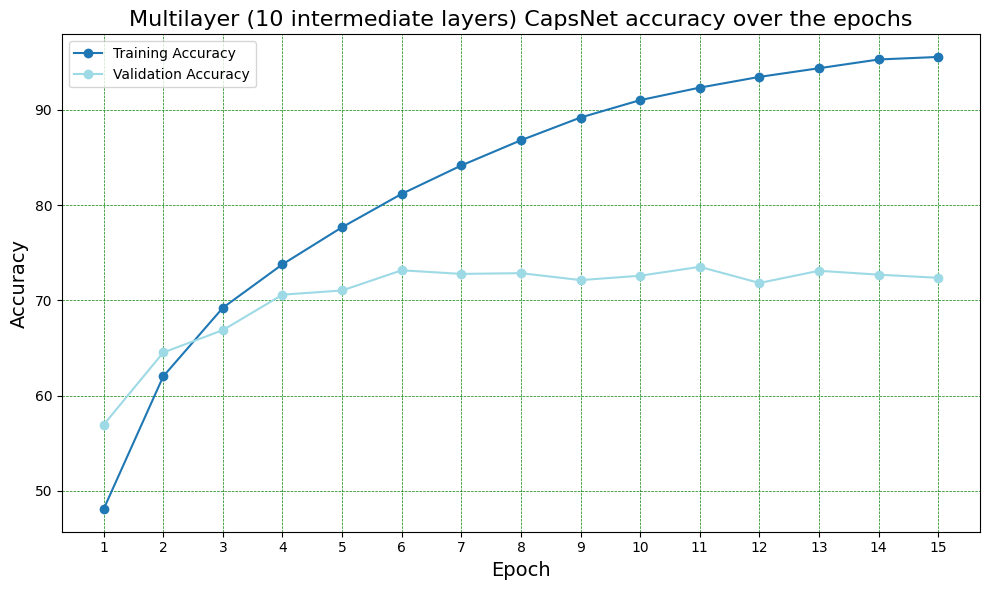

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (10 intermediate layers) CapsNet accuracy over the epochs')

In [ ]:
# print("Disconnecting runtime after 20 seconds")

# time.sleep(20)

# from google.colab import runtime
# runtime.unassign()

Disconnecting runtime after 20 seconds


## 11 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=11
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

100%|██████████| 170498071/170498071 [00:12<00:00, 13202864.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
multilayer_inter11_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter11_capsnet_cifar10_model.name = 'multilayer_inter11_capsnet_cifar10_model'
multilayer_inter11_capsnet_cifar10_model = multilayer_inter11_capsnet_cifar10_model.to(device)
multilayer_inter11_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter11_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

03/03 04:05:41 AM | multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7992, Top 1 Acc=7.81, Top 5 Acc=59.38
INFO:capsnet:multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7992, Top 1 Acc=7.81, Top 5 Acc=59.38
03/03 04:06:11 AM | multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4788, Top 1 Acc=28.37, Top 5 Acc=75.82
INFO:capsnet:multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4788, Top 1 Acc=28.37, Top 5 Acc=75.82
03/03 04:06:41 AM | multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4493, Top 1 Acc=33.25, Top 5 Acc=79.97
INFO:capsnet:multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4493, Top 1 Acc=33.25, Top 5 Acc=79.97
03/03 04:07:10 AM | multilayer_inter11_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4280, Top 1 Acc=36.59, Top 5 Acc

CPU times: user 1h 27min 39s, sys: 5min 58s, total: 1h 33min 38s
Wall time: 1h 33min 25s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter11_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter11_capsnet_cifar10_model.pt')

best_multilayer_inter11_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter11_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter11_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter11_capsnet_cifar10_model.name = 'best_multilayer_inter11_capsnet_cifar10_model'
best_multilayer_inter11_capsnet_cifar10_model = best_multilayer_inter11_capsnet_cifar10_model.to(device)
best_multilayer_inter11_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter11_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter11_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 05:39:05 AM | best_multilayer_inter11_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
INFO:capsnet:best_multilayer_inter11_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=95.312
03/03 05:39:05 AM | best_multilayer_inter11_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=77.344, Top 5 Acc=96.094
INFO:capsnet:best_multilayer_inter11_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=77.344, Top 5 Acc=96.094
03/03 05:39:05 AM | best_multilayer_inter11_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=96.354
INFO:capsnet:best_multilayer_inter11_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=73.958, Top 5 Acc=96.354
03/03 05:39:06 AM | best_multilayer_inter11_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=73.438, Top 5 Acc=94.922
INFO:capsnet:best_multilayer_inter11_capsnet_cifar10_model - Iteratio

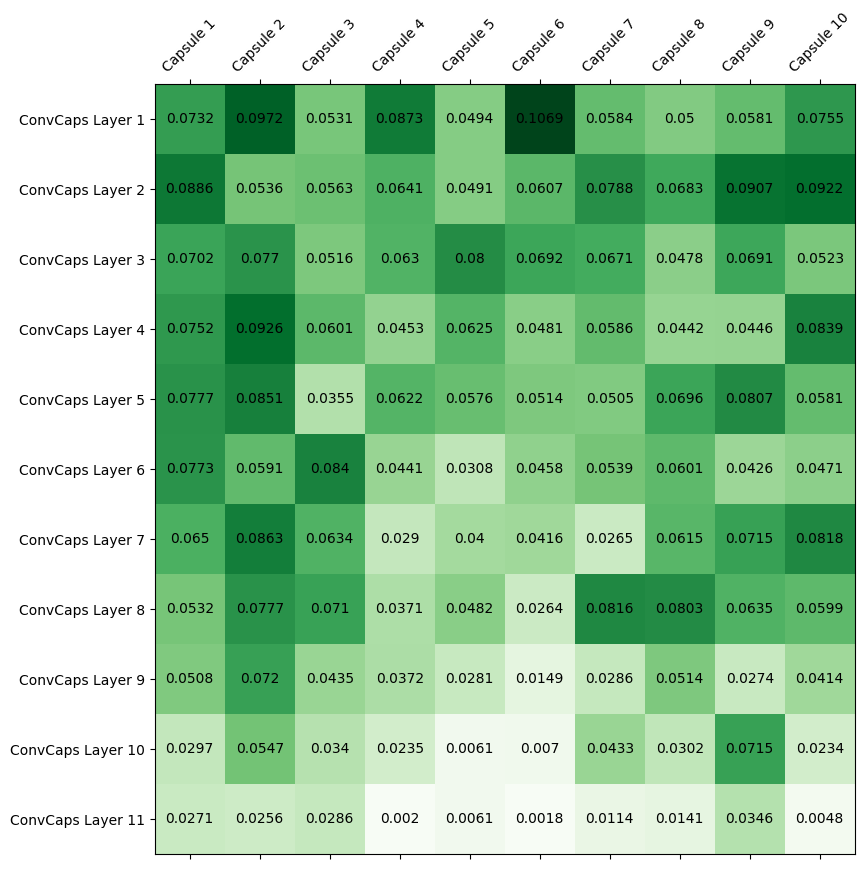

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter11_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    trained_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter11_capsnet_cifar10_model_Epoch{}_of_15.pt'.format(epoch))

    multilayer_capsnet_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                   model_conv_config=model_conv_config,
                                                   prim_caps_channels=prim_caps_channels,
                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

    multilayer_capsnet_model.load_state_dict(trained_model['model_state_dict'])

    multilayer_capsnet_model.name = 'trained_multilayer_inter11_capsnet_cifar10_model_epoch{}'.format(epoch)
    multilayer_capsnet_model = multilayer_capsnet_model.to(device)

    utils.extract_convcaps_activations(multilayer_capsnet_model, test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 05:39:43 AM | trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=95.312
INFO:capsnet:trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=95.312
03/03 05:39:43 AM | trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=96.094
INFO:capsnet:trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=96.094
03/03 05:39:43 AM | trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=56.771, Top 5 Acc=94.792
INFO:capsnet:trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=56.771, Top 5 Acc=94.792
03/03 05:39:44 AM | trained_multilayer_inter11_capsnet_cifar10_model_epoch1 - Iterations=4/157, Batch Size=64, Top 1 Acc=54.297, Top 5 Acc=94.531

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar11_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter11_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar11_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar11_model['epoch_accuracy']

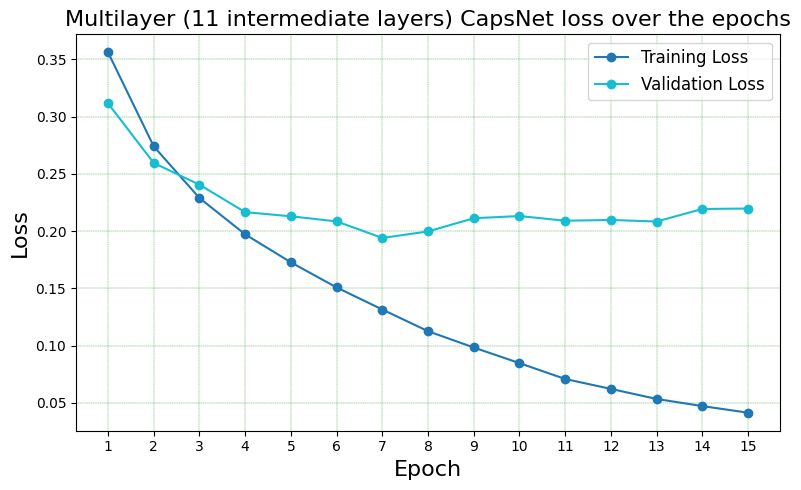

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (11 intermediate layers) CapsNet loss over the epochs')

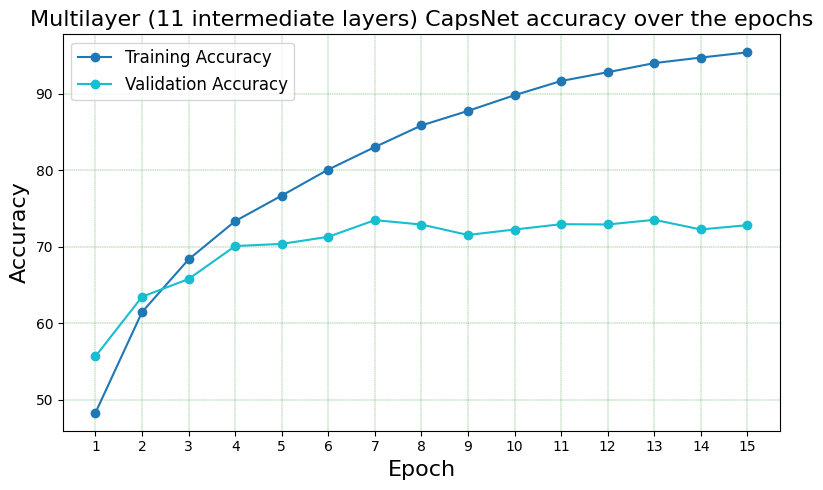

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (11 intermediate layers) CapsNet accuracy over the epochs')

## 12 Intermediate Layered CapsNet

In [ ]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"
batch_size=64
n_epochs=15
n_class=10

n_caps_layers=12
prim_caps_channels=10
prim_caps_dim=8

model_conv_config = {'in_img_h': 32,
                     'in_img_w': 32,
                     'in_img_c': 3,
                     'kernel_size': [3, 3, 3, 3],
                     'stride': [1, 2, 1, 2],
                     'padding': [1, 1, 1, 0]}

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

criterion = caps.CapsNetLoss(n_class=n_class)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
multilayer_inter12_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                               model_conv_config=model_conv_config, prim_caps_channels=prim_caps_channels,
                                                               prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

multilayer_inter12_capsnet_cifar10_model.name = 'multilayer_inter12_capsnet_cifar10_model'
multilayer_inter12_capsnet_cifar10_model = multilayer_inter12_capsnet_cifar10_model.to(device)
multilayer_inter12_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
%%time
best_trained_model_path, _, _ = mtt.train_capsnet(n_epochs,
                                                  multilayer_inter12_capsnet_cifar10_model,
                                                  criterion,
                                                  train_loader,
                                                  test_loader,
                                                  CIFAR10_TRAIN_DIR,
                                                  logger,
                                                  device=device)

03/03 05:44:44 AM | multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7951, Top 1 Acc=9.38, Top 5 Acc=48.44
INFO:capsnet:multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(0/782), Loss=0.7951, Top 1 Acc=9.38, Top 5 Acc=48.44
03/03 05:45:16 AM | multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4914, Top 1 Acc=26.11, Top 5 Acc=74.13
INFO:capsnet:multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(64/782), Loss=0.4914, Top 1 Acc=26.11, Top 5 Acc=74.13
03/03 05:45:48 AM | multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4575, Top 1 Acc=31.31, Top 5 Acc=79.05
INFO:capsnet:multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(128/782), Loss=0.4575, Top 1 Acc=31.31, Top 5 Acc=79.05
03/03 05:46:20 AM | multilayer_inter12_capsnet_cifar10_model Training - Epoch=1, Iteration=(192/782), Loss=0.4395, Top 1 Acc=34.44, Top 5 Acc

CPU times: user 1h 33min 18s, sys: 6min 27s, total: 1h 39min 45s
Wall time: 1h 39min 28s


### Export ConvCaps Activation

In [ ]:
trained_multilayer_inter12_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Best_multilayer_inter12_capsnet_cifar10_model.pt')

best_multilayer_inter12_capsnet_cifar10_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                                    model_conv_config=model_conv_config,
                                                                    prim_caps_channels=prim_caps_channels,
                                                                    prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

best_multilayer_inter12_capsnet_cifar10_model.load_state_dict(trained_multilayer_inter12_capsnet_cifar10_model['model_state_dict'])

best_multilayer_inter12_capsnet_cifar10_model.name = 'best_multilayer_inter12_capsnet_cifar10_model'
best_multilayer_inter12_capsnet_cifar10_model = best_multilayer_inter12_capsnet_cifar10_model.to(device)
best_multilayer_inter12_capsnet_cifar10_model.eval()

CapsuleNetwork(
  (conv_layer_1): ConvLayer(
    (conv_layer): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_2): ConvLayer(
    (conv_layer): Conv2d(20, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_layer_3): ConvLayer(
    (conv_layer): Conv2d(40, 80, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): Conv2d(80, 80, kernel_size=(3, 3), stride=(2, 2))
  )
  (intermediate_caps): Sequential(
    (intermediate_convcaps_layer_1): ConvCapsLayer()
    (intermediate_convcaps_layer_2): ConvCapsLayer()
    (intermediate_convcaps_layer_3): ConvCapsLayer()
    (intermediate_convca

In [ ]:
capsnet_inter12_convcaps_activations = utils.extract_convcaps_activations(best_multilayer_inter12_capsnet_cifar10_model,
                                                                          test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 07:24:14 AM | best_multilayer_inter12_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=96.875
INFO:capsnet:best_multilayer_inter12_capsnet_cifar10_model - Iterations=1/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=96.875
03/03 07:24:14 AM | best_multilayer_inter12_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=74.219, Top 5 Acc=97.656
INFO:capsnet:best_multilayer_inter12_capsnet_cifar10_model - Iterations=2/157, Batch Size=64, Top 1 Acc=74.219, Top 5 Acc=97.656
03/03 07:24:14 AM | best_multilayer_inter12_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.917
INFO:capsnet:best_multilayer_inter12_capsnet_cifar10_model - Iterations=3/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.917
03/03 07:24:14 AM | best_multilayer_inter12_capsnet_cifar10_model - Iterations=4/157, Batch Size=64, Top 1 Acc=75.000, Top 5 Acc=97.266
INFO:capsnet:best_multilayer_inter12_capsnet_cifar10_model - Iteratio

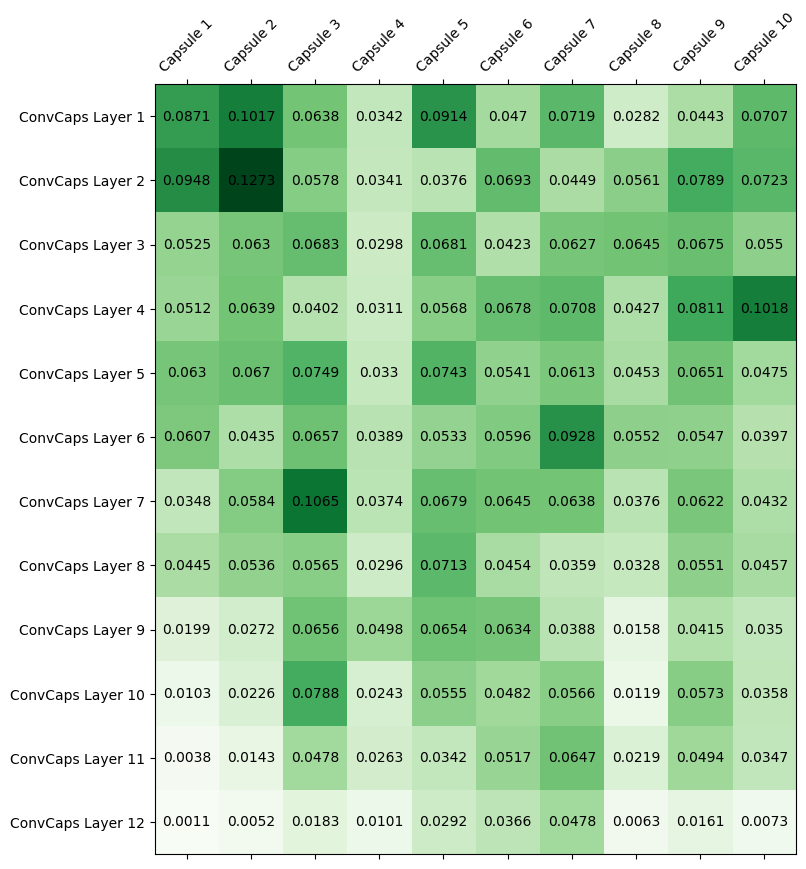

In [ ]:
utils.plot_caps_layers_activations(capsnet_inter12_convcaps_activations, n_caps=prim_caps_channels,
                                   n_caps_layers=n_caps_layers, text_en=1)

In [ ]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    trained_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter12_capsnet_cifar10_model_Epoch{}_of_15.pt'.format(epoch))

    multilayer_capsnet_model = caps.CapsuleNetwork(in_img_c=3, in_img_h=32, in_img_w=32, n_class=n_class,
                                                   model_conv_config=model_conv_config,
                                                   prim_caps_channels=prim_caps_channels,
                                                   prim_caps_dim=prim_caps_dim, n_caps_layers=n_caps_layers)

    multilayer_capsnet_model.load_state_dict(trained_model['model_state_dict'])

    multilayer_capsnet_model.name = 'trained_multilayer_inter12_capsnet_cifar10_model_epoch{}'.format(epoch)
    multilayer_capsnet_model = multilayer_capsnet_model.to(device)

    utils.extract_convcaps_activations(multilayer_capsnet_model, test_loader, logger, CIFAR10_TRAIN_DIR, device)

03/03 07:24:27 AM | trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=93.750
INFO:capsnet:trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=1/157, Batch Size=64, Top 1 Acc=57.812, Top 5 Acc=93.750
03/03 07:24:27 AM | trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=59.375, Top 5 Acc=93.750
INFO:capsnet:trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=2/157, Batch Size=64, Top 1 Acc=59.375, Top 5 Acc=93.750
03/03 07:24:27 AM | trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=57.292, Top 5 Acc=94.271
INFO:capsnet:trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=3/157, Batch Size=64, Top 1 Acc=57.292, Top 5 Acc=94.271
03/03 07:24:27 AM | trained_multilayer_inter12_capsnet_cifar10_model_epoch1 - Iterations=4/157, Batch Size=64, Top 1 Acc=55.859, Top 5 Acc=93.359

### Plots for losses and accuracies

In [ ]:
multilayer_capsnet_cifar10_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter12_capsnet_cifar10_model_Epoch15_of_15.pt')

epoch_loss = multilayer_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = multilayer_capsnet_cifar10_model['epoch_accuracy']

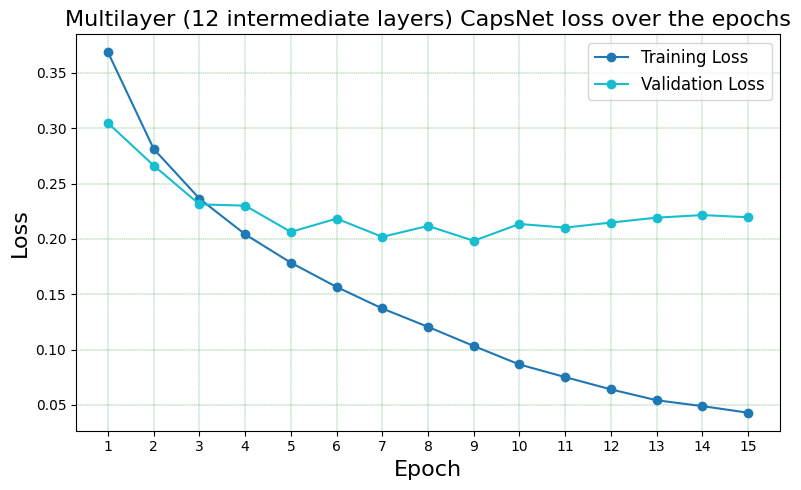

In [ ]:
utils.plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'], 'Epoch', 'Loss',
                      'Multilayer (12 intermediate layers) CapsNet loss over the epochs')

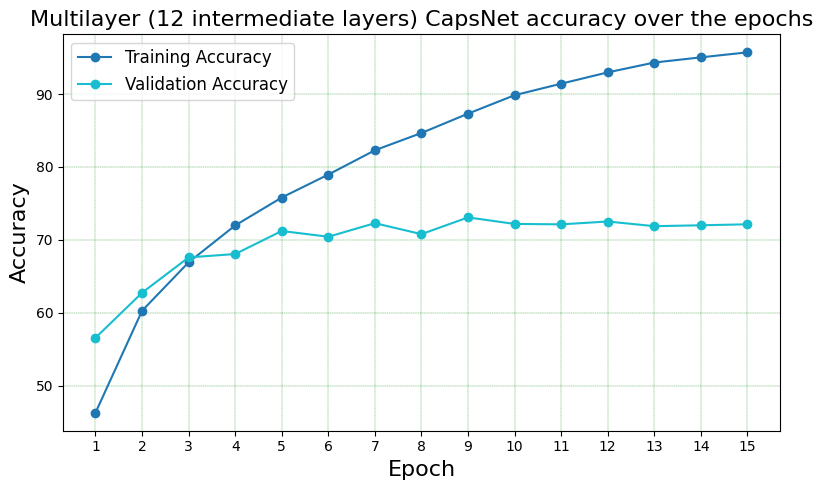

In [ ]:
utils.plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'], 'Epoch', 'Accuracy',
                      'Multilayer (12 intermediate layers) CapsNet accuracy over the epochs')

In [ ]:
print("Disconnecting runtime after 5 seconds")

time.sleep(5)

from google.colab import runtime
runtime.unassign()

Disconnecting runtime after 5 seconds


## Plots for Base and All Multilayer CapsNet

In [11]:
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/10Caps8Dim/"

base_capsnet_cifar10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_base_capsnet_cifar10_model_Epoch30_of_30.pt', map_location=device)
multilayer_capsnet_inter1_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter1_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter2_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter2_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter3_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter3_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter4_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter4_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter5_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter5_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter6_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter6_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter7_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter7_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter8_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter8_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter9_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter9_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)
multilayer_capsnet_inter10_model_data = torch.load(CIFAR10_TRAIN_DIR+'Trained_multilayer_inter10_capsnet_cifar10_model_Epoch15_of_15.pt', map_location=device)

In [12]:
models = [base_capsnet_cifar10_model_data,
          multilayer_capsnet_inter1_model_data,
          multilayer_capsnet_inter2_model_data,
          multilayer_capsnet_inter3_model_data,
          multilayer_capsnet_inter4_model_data,
          multilayer_capsnet_inter5_model_data,
          multilayer_capsnet_inter6_model_data,
          multilayer_capsnet_inter7_model_data,
          multilayer_capsnet_inter8_model_data,
          multilayer_capsnet_inter9_model_data,
          multilayer_capsnet_inter10_model_data]

legends = ['Base',
           '1 InterLayer',
           '2 InterLayers',
           '3 InterLayers',
           '4 InterLayers',
           '5 InterLayers',
           '6 InterLayers',
           '7 InterLayers',
           '8 InterLayers',
           '9 InterLayers',
           '10 InterLayers']

n_epochs = 15

epoch_losses = np.zeros((len(models), n_epochs))
epoch_accuracies = np.zeros((len(models), n_epochs))

for indx, model in enumerate(models):
    epoch_losses[indx] = model['epoch_loss'][:,:15][1]
    epoch_accuracies[indx] = model['epoch_accuracy'][:, :15][1]

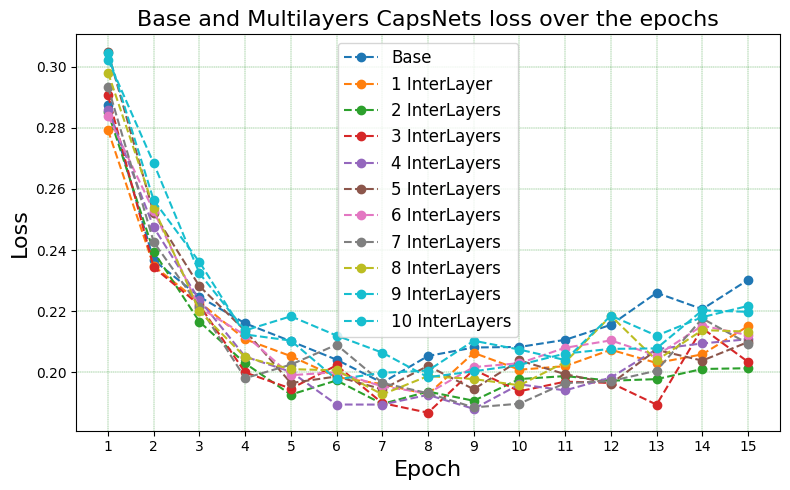

In [13]:
utils.plot_line_chart(epoch_losses, legends, 'Epoch', 'Loss',
                      'Base and Multilayers CapsNets loss over the epochs', marker='o', line='--')

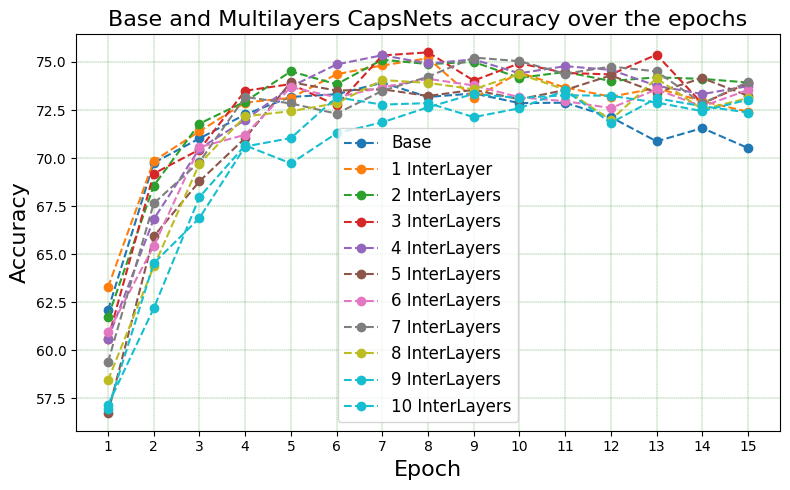

In [14]:
utils.plot_line_chart(epoch_accuracies, legends, 'Epoch', 'Accuracy',
                      'Base and Multilayers CapsNets accuracy over the epochs', marker='o', line='--')